In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0).T

# Apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)

scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (205, 44663)
meth_df: (205, 419542)
cnv_df: (205, 56756)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)


Epoch 1/400 | Train Loss: 0.2459 | Val Loss: 0.0026
Epoch 10/400 | Train Loss: 0.1183 | Val Loss: 0.0000
Epoch 20/400 | Train Loss: 0.0639 | Val Loss: 0.0003
Epoch 10/400 | Train Loss: 0.1183 | Val Loss: 0.0000
Epoch 20/400 | Train Loss: 0.0639 | Val Loss: 0.0003
Epoch 30/400 | Train Loss: 0.0379 | Val Loss: 0.0059
Early stopping triggered!
Epoch 30/400 | Train Loss: 0.0379 | Val Loss: 0.0059
Early stopping triggered!


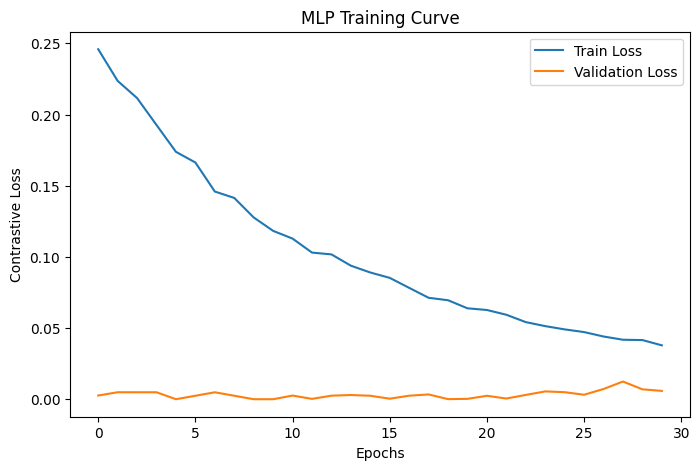

Epoch 1/400 | Train Loss: 0.2381 | Val Loss: 0.0028
Epoch 10/400 | Train Loss: 0.1129 | Val Loss: 0.0001
Epoch 10/400 | Train Loss: 0.1129 | Val Loss: 0.0001
Epoch 20/400 | Train Loss: 0.0618 | Val Loss: 0.0061
Epoch 20/400 | Train Loss: 0.0618 | Val Loss: 0.0061
Early stopping triggered!
Early stopping triggered!


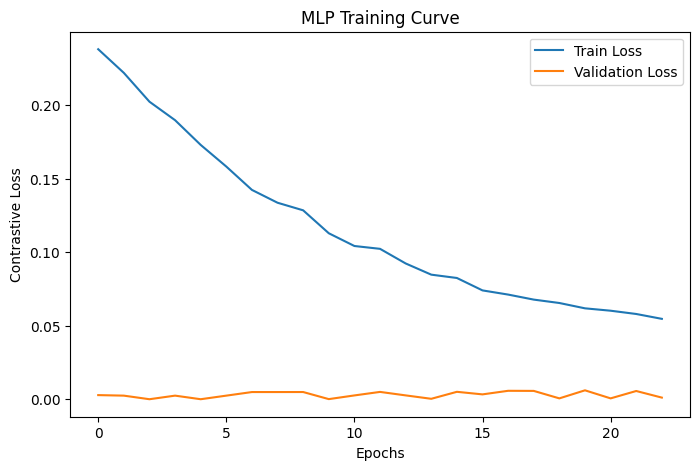

Epoch 1/400 | Train Loss: 0.2515 | Val Loss: 0.0026
Epoch 10/400 | Train Loss: 0.1421 | Val Loss: 0.0049
Epoch 10/400 | Train Loss: 0.1421 | Val Loss: 0.0049
Epoch 20/400 | Train Loss: 0.0853 | Val Loss: 0.0027
Epoch 20/400 | Train Loss: 0.0853 | Val Loss: 0.0027
Epoch 30/400 | Train Loss: 0.0548 | Val Loss: 0.0001
Epoch 30/400 | Train Loss: 0.0548 | Val Loss: 0.0001
Epoch 40/400 | Train Loss: 0.0337 | Val Loss: 0.0043
Early stopping triggered!
Epoch 40/400 | Train Loss: 0.0337 | Val Loss: 0.0043
Early stopping triggered!


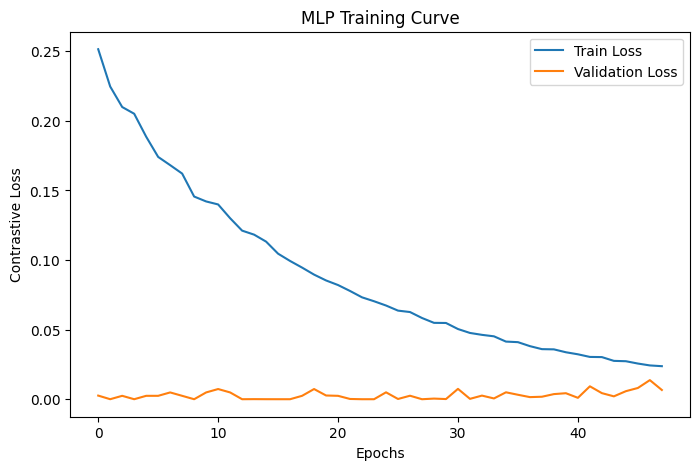

Individual latent shapes:
  - Gene latent: torch.Size([205, 64])
  - Methylation latent: torch.Size([205, 64])
  - CNV latent: torch.Size([205, 64])


In [4]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ MLP Feature Extractor with Dropout ------------------
class MLP(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(MLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.feature_extractor(x)

# ------------------ Training with contrastive learning approach ------------------
def train_mlp(model, data, epochs=400, patience=20, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # For unsupervised feature learning, we use a simple contrastive approach
    # We create positive pairs by adding small noise and negative pairs from different samples
    def create_pairs(X, noise_std=0.1):
        # Positive pairs: original + noisy version
        noise = torch.randn_like(X) * noise_std
        X_pos = X + noise
        
        # Negative pairs: random shuffle
        idx = torch.randperm(X.size(0))
        X_neg = X[idx]
        
        return X_pos, X_neg

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        
        # Create positive and negative pairs
        X_pos, X_neg = create_pairs(X_train)
        
        # Get embeddings
        z_orig = model(X_train)
        z_pos = model(X_pos)
        z_neg = model(X_neg)
        
        # Contrastive loss: pull positive pairs together, push negative pairs apart
        pos_loss = torch.mean((z_orig - z_pos) ** 2)
        neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_orig - z_neg, dim=1), min=0) ** 2)
        loss = pos_loss + 0.1 * neg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation - use same approach
        model.eval()
        with torch.no_grad():
            X_val_pos, X_val_neg = create_pairs(X_val)
            z_val_orig = model(X_val)
            z_val_pos = model(X_val_pos)
            z_val_neg = model(X_val_neg)
            
            val_pos_loss = torch.mean((z_val_orig - z_val_pos) ** 2)
            val_neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_val_orig - z_val_neg, dim=1), min=0) ** 2)
            val_loss = val_pos_loss + 0.1 * val_neg_loss

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Contrastive Loss")
    plt.title("MLP Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

mlp_gene = MLP(gene_dim, latent_dim=64).to(device)
mlp_meth = MLP(meth_dim, latent_dim=64).to(device)
mlp_cnv  = MLP(cnv_dim,  latent_dim=64).to(device)

mlp_gene = train_mlp(mlp_gene, gene, normalize=True)
mlp_meth = train_mlp(mlp_meth, meth, normalize=True)
mlp_cnv  = train_mlp(mlp_cnv, cnv, normalize=True)

# ------------------ Extract latent embeddings (NO FUSION) ------------------
mlp_gene.eval(); mlp_meth.eval(); mlp_cnv.eval()
with torch.no_grad():
    z_gene = mlp_gene(gene.to(device))
    z_meth = mlp_meth(meth.to(device))
    z_cnv  = mlp_cnv(cnv.to(device))

print("Individual latent shapes:")
print(f"  - Gene latent: {z_gene.shape}")
print(f"  - Methylation latent: {z_meth.shape}")
print(f"  - CNV latent: {z_cnv.shape}")


# Individual Omics Machine Learning Evaluation

Train multiple classifiers on each individual omic's latent embeddings separately and compare performance.

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import seaborn as sns

# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Get labels
labels = labels_df.loc[common_samples].values.ravel()

print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

# Prepare individual omics embeddings
omics_data = {
    'Gene Expression': z_gene.cpu().numpy(),
    'Methylation': z_meth.cpu().numpy(),
    'Copy Number Variation': z_cnv.cpu().numpy()
}

print("\nIndividual omics embedding shapes:")
for name, data in omics_data.items():
    print(f"  {name}: {data.shape}")

Samples with labels: 205
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]

Individual omics embedding shapes:
  Gene Expression: (205, 64)
  Methylation: (205, 64)
  Copy Number Variation: (205, 64)


# Individual Omics MLP Analysis

Analyzing the extracted embeddings from individual omics MLPs.

In [15]:
# C-index calculation function (same as AE pipeline)
from sklearn.metrics import roc_auc_score

def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (Concordance Index) for multi-class classification.
    Uses macro-averaged AUC for multi-class problems.
    """
    try:
        # For multi-class, use macro-averaged AUC as C-index
        c_index = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
        return c_index
    except:
        return 0.0

print("="*100)
print("INDIVIDUAL OMICS MLP EMBEDDINGS ANALYSIS")
print("="*100)

# Display embedding statistics
for omic_name, omic_data in omics_data.items():
    print(f"\n{omic_name} Embeddings:")
    print(f"  Shape: {omic_data.shape}")
    print(f"  Mean: {omic_data.mean():.4f}")
    print(f"  Std: {omic_data.std():.4f}")
    print(f"  Min: {omic_data.min():.4f}")
    print(f"  Max: {omic_data.max():.4f}")

print("\n✅ MLP embeddings analysis completed!")

INDIVIDUAL OMICS MLP EMBEDDINGS ANALYSIS

Gene Expression Embeddings:
  Shape: (205, 64)
  Mean: 0.0010
  Std: 0.2259
  Min: -0.6087
  Max: 0.6649

Methylation Embeddings:
  Shape: (205, 64)
  Mean: -0.0132
  Std: 0.1804
  Min: -0.5747
  Max: 0.4778

Copy Number Variation Embeddings:
  Shape: (205, 64)
  Mean: -0.0161
  Std: 0.1017
  Min: -0.4904
  Max: 0.4035

✅ MLP embeddings analysis completed!


COMPREHENSIVE INDIVIDUAL OMICS EMBEDDINGS VISUALIZATION

📊 Processing Gene Expression...
Computing PCA for Gene Expression...
Computing t-SNE for Gene Expression...


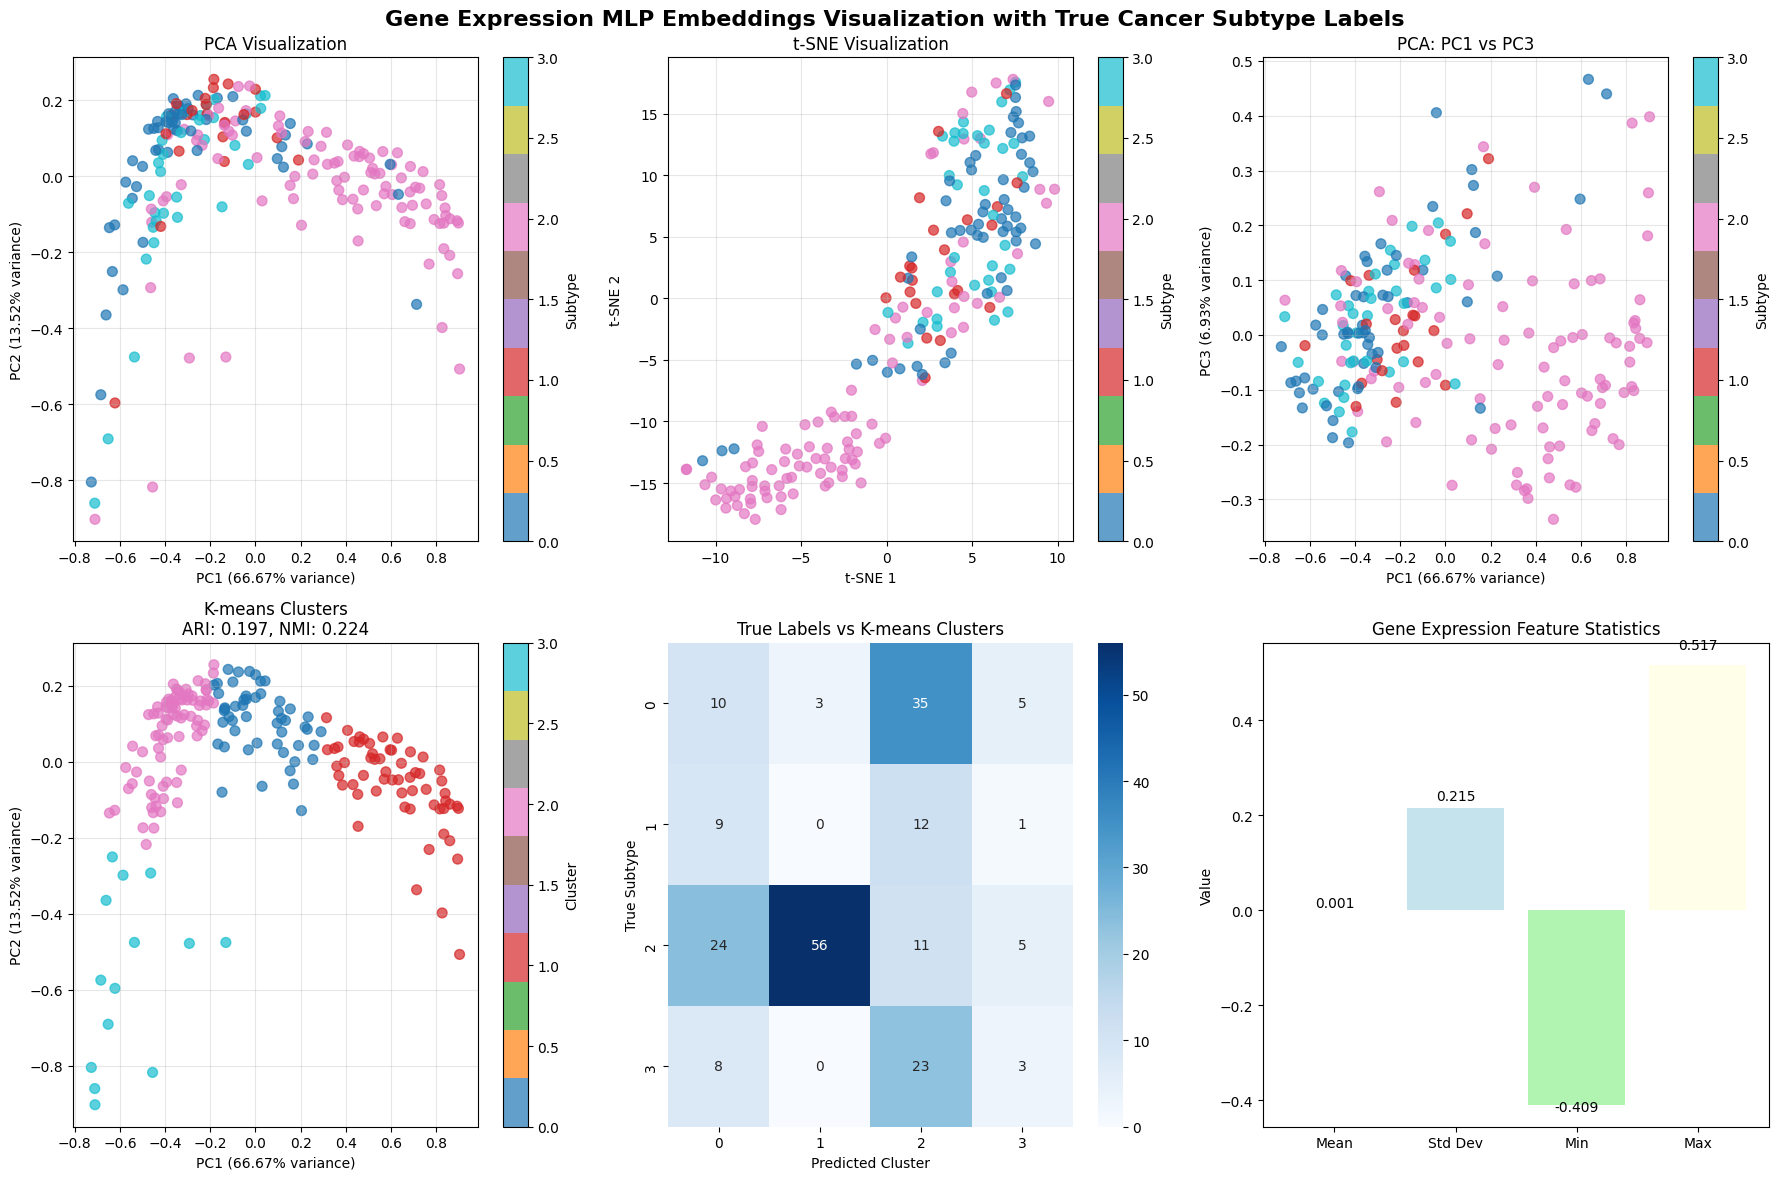


📊 Processing Methylation...
Computing PCA for Methylation...
Computing t-SNE for Methylation...


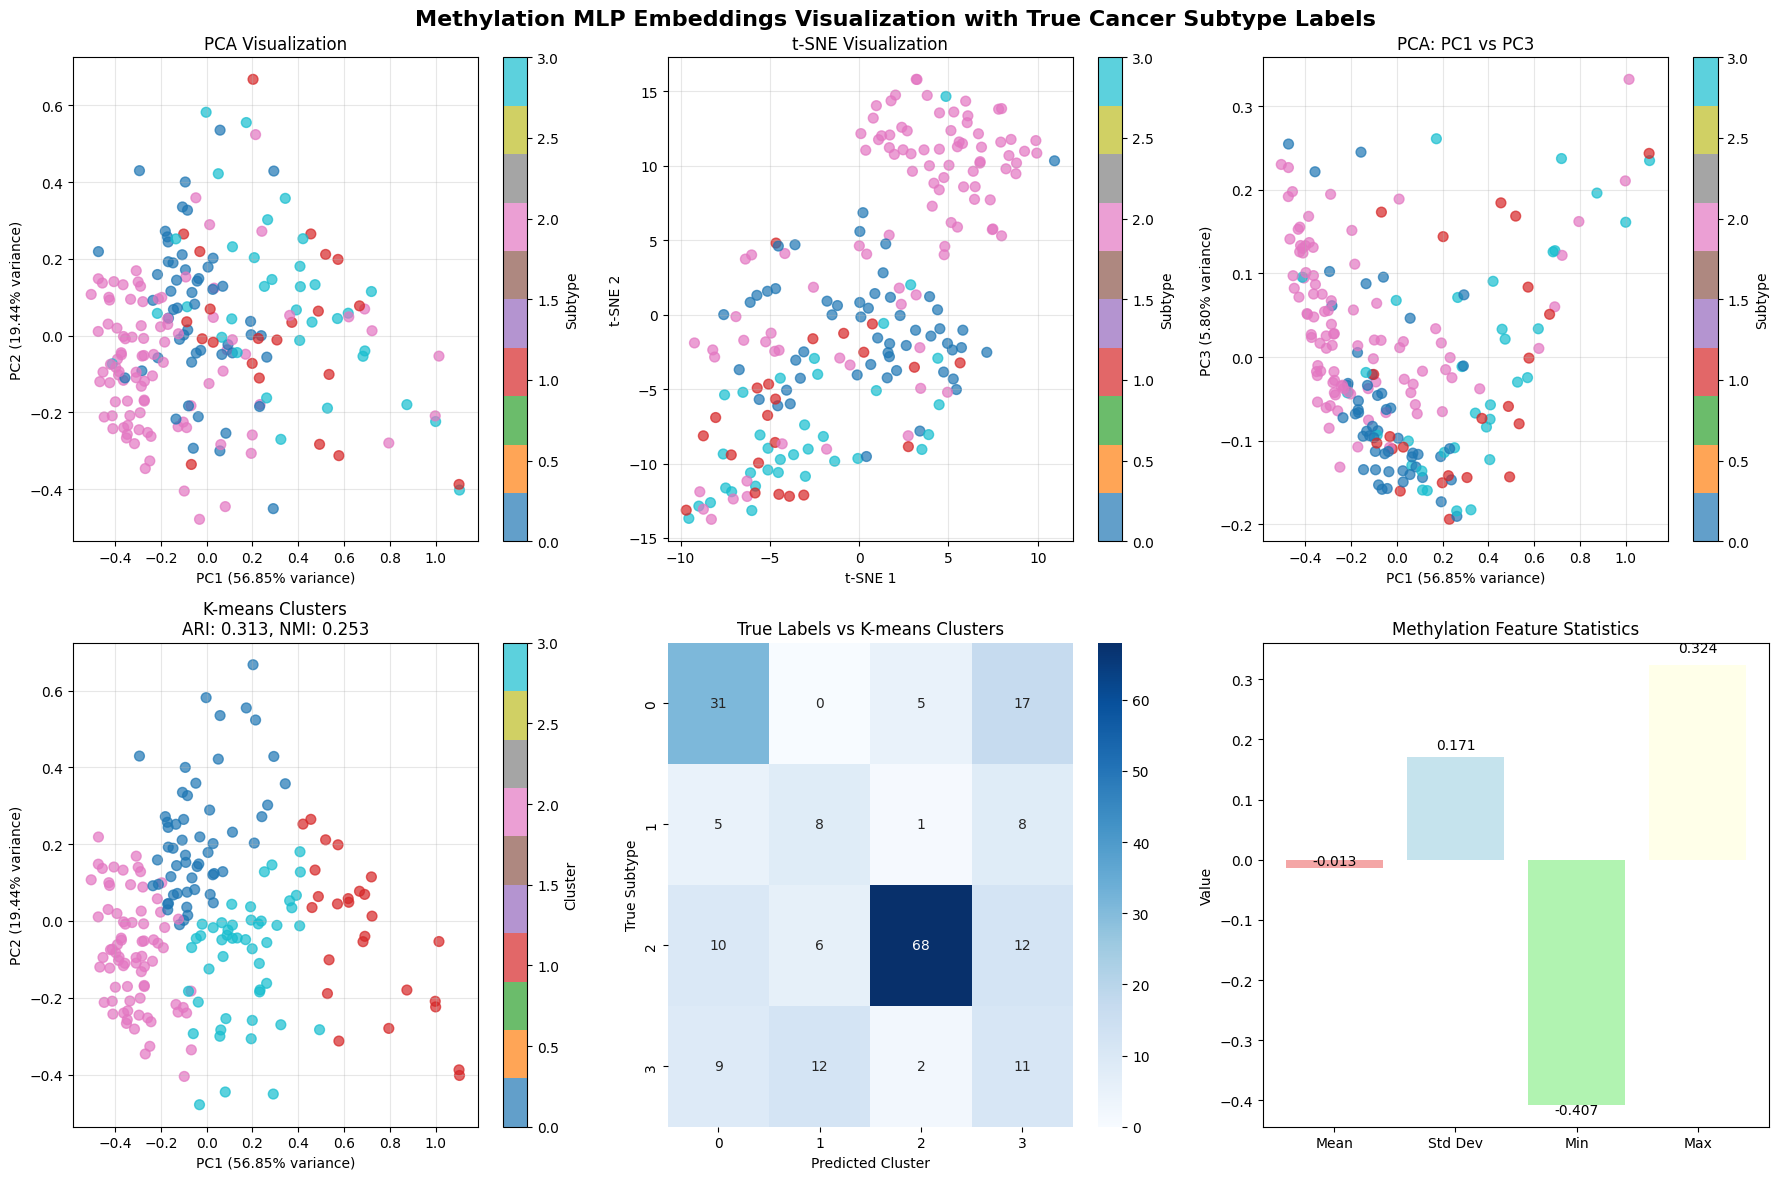


📊 Processing Copy Number Variation...
Computing PCA for Copy Number Variation...
Computing t-SNE for Copy Number Variation...


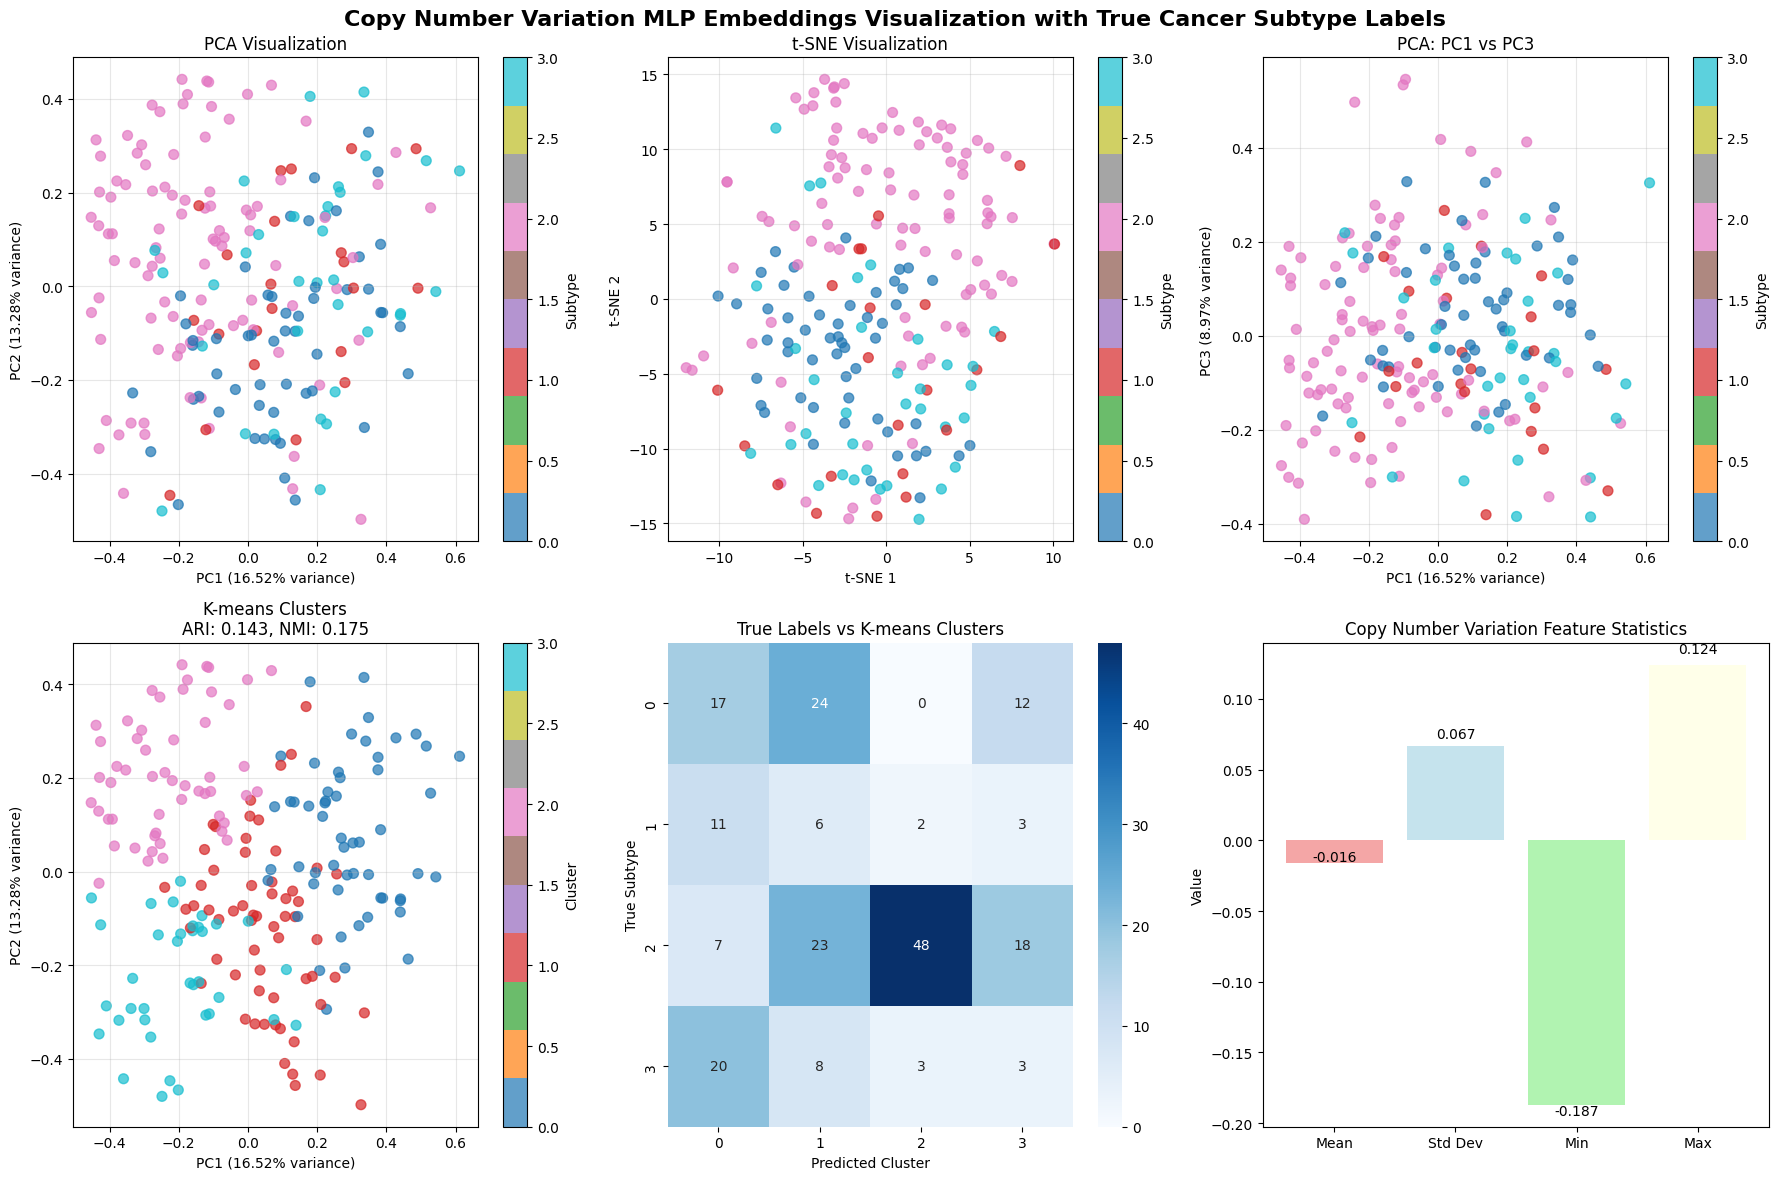

✅ Comprehensive individual omics embeddings visualization completed!


In [7]:
# Comprehensive Embedding Visualization for Each Omic (same as AE pipeline)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*100)
print("COMPREHENSIVE INDIVIDUAL OMICS EMBEDDINGS VISUALIZATION")
print("="*100)

# Process each omic separately with comprehensive visualization
for omic_name, omic_data in omics_data.items():
    print(f"\n📊 Processing {omic_name}...")
    
    # Create comprehensive visualization for this omic
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{omic_name} MLP Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

    # 1. PCA 2D visualization
    print(f"Computing PCA for {omic_name}...")
    pca_2d = PCA(n_components=2, random_state=42)
    embeddings_pca_2d = pca_2d.fit_transform(omic_data)

    scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                                 c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    axes[0, 0].set_title('PCA Visualization')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

    # 2. t-SNE 2D visualization
    print(f"Computing t-SNE for {omic_name}...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_tsne_2d = tsne_2d.fit_transform(omic_data)

    scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                                 c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 1].set_xlabel('t-SNE 1')
    axes[0, 1].set_ylabel('t-SNE 2')
    axes[0, 1].set_title('t-SNE Visualization')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

    # 3. PCA 3D to 2D projections (PC1 vs PC3)
    pca_3d = PCA(n_components=3, random_state=42)
    embeddings_pca_3d = pca_3d.fit_transform(omic_data)

    scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                                 c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
    axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
    axes[0, 2].set_title('PCA: PC1 vs PC3')
    axes[0, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

    # 4. Cluster analysis comparison
    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    predicted_clusters = kmeans.fit_predict(omic_data)

    # Calculate clustering metrics
    ari_score = adjusted_rand_score(labels, predicted_clusters)
    nmi_score = normalized_mutual_info_score(labels, predicted_clusters)

    scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                                 c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
    axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

    # 5. Confusion matrix: True vs Predicted
    cm = confusion_matrix(labels, predicted_clusters)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted Cluster')
    axes[1, 1].set_ylabel('True Subtype')
    axes[1, 1].set_title('True Labels vs K-means Clusters')

    # 6. Feature statistics
    feature_stats = {
        'Mean': np.mean(omic_data, axis=0).mean(),
        'Std Dev': np.mean(omic_data, axis=0).std(),
        'Min': np.mean(omic_data, axis=0).min(),
        'Max': np.mean(omic_data, axis=0).max()
    }
    
    bars = axes[1, 2].bar(feature_stats.keys(), feature_stats.values(), 
                          alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
    axes[1, 2].set_ylabel('Value')
    axes[1, 2].set_title(f'{omic_name} Feature Statistics')
    
    # Add value labels on bars
    for bar, (key, val) in zip(bars, feature_stats.items()):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                        f'{val:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

print("✅ Comprehensive individual omics embeddings visualization completed!")

In [8]:
# Traditional ML Classification for Each Omic Separately (same as AE pipeline)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

print("\n" + "="*100)
print("📊 TRADITIONAL ML CLASSIFICATION ON INDIVIDUAL OMICS")
print("="*100)

# Define classifiers (same as AE pipeline)
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Store results for each omic separately
omic_results = {}

# Process each omic separately
for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"🧬 PROCESSING: {omic_name}")
    print(f"{'='*100}")
    
    # Split data for this omic
    X_train, X_test, y_train, y_test = train_test_split(
        omic_data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
    print(f"Test class distribution: {np.bincount(y_test.astype(int))}")
    
    # Store results for this omic
    results = []
    
    print(f"\nTraining and evaluating classifiers for {omic_name}...")
    print("-" * 80)
    
    for name, clf in classifiers.items():
        # Train the model
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
        precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
        recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
        recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
        c_index = concordance_index(y_test, y_pred_proba)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision (Macro)': precision_macro,
            'Precision (Micro)': precision_micro,
            'Recall (Macro)': recall_macro,
            'Recall (Micro)': recall_micro,
            'F1 (Macro)': f1_macro,
            'F1 (Micro)': f1_micro,
            'C-Index': c_index
        })
    
    # Store results for this omic
    omic_results[omic_name] = {
        'results': results,
        'X_train': X_train,
        'X_test': X_test, 
        'y_train': y_train,
        'y_test': y_test,
        'classifiers': classifiers
    }
    
    print(f"✅ {omic_name} classification completed!")

print(f"\n{'='*100}")
print("✅ All individual omics classification completed!")
print(f"{'='*100}")


📊 TRADITIONAL ML CLASSIFICATION ON INDIVIDUAL OMICS

🧬 PROCESSING: Gene Expression
Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]

Training and evaluating classifiers for Gene Expression...
--------------------------------------------------------------------------------


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Gene Expression classification completed!

🧬 PROCESSING: Methylation
Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]

Training and evaluating classifiers for Methylation...
--------------------------------------------------------------------------------


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Methylation classification completed!

🧬 PROCESSING: Copy Number Variation
Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]

Training and evaluating classifiers for Copy Number Variation...
--------------------------------------------------------------------------------
✅ Copy Number Variation classification completed!

✅ All individual omics classification completed!
✅ Copy Number Variation classification completed!

✅ All individual omics classification completed!


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [9]:
# Native MLP Classifiers for Each Omic (same hyperparameters as AE pipeline)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_mlp_classifier(model, X_train, y_train, X_test, y_test, epochs=200, patience=15):
    """Train MLP classifier with early stopping (same as AE pipeline)"""
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

print("\n" + "="*100)
print("🤖 NATIVE MLP CLASSIFIERS FOR INDIVIDUAL OMICS")
print("="*100)

num_classes = len(np.unique(labels))

# Train native MLP classifiers for each omic
for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"🤖 TRAINING NATIVE MLP CLASSIFIERS: {omic_name}")
    print(f"{'='*100}")
    
    # Get train/test splits for this omic
    X_train = omic_results[omic_name]['X_train']
    X_test = omic_results[omic_name]['X_test']
    y_train = omic_results[omic_name]['y_train']
    y_test = omic_results[omic_name]['y_test']
    
    input_dim = omic_data.shape[1]
    
    print("Training Native MLP Classifiers...")
    print("-" * 50)
    
    # Shallow MLP Classifier
    shallow_mlp = MLPClassifier(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
    print(f"Training Shallow MLP Classifier for {omic_name}...")
    shallow_mlp = train_mlp_classifier(shallow_mlp, X_train, y_train, X_test, y_test)
    
    # Deep MLP Classifier  
    deep_mlp = MLPClassifier(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
    print(f"\nTraining Deep MLP Classifier for {omic_name}...")
    deep_mlp = train_mlp_classifier(deep_mlp, X_train, y_train, X_test, y_test)
    
    # Evaluate MLP classifiers
    def evaluate_mlp_classifier(model, X_test, y_test, model_name):
        """Evaluate MLP classifier and return metrics"""
        import torch.nn.functional as F
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            outputs = model(X_test_tensor)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            _, predicted = torch.max(outputs.data, 1)
            y_pred = predicted.cpu().numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        c_index = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
        precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
        precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
        recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
        recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
        
        return {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision (Macro)': precision_macro,
            'Precision (Micro)': precision_micro,
            'Recall (Macro)': recall_macro,
            'Recall (Micro)': recall_micro,
            'F1 (Macro)': f1_macro,
            'F1 (Micro)': f1_micro,
            'C-Index': c_index
        }
    
    # Evaluate models
    mlp_results = []
    mlp_results.append(evaluate_mlp_classifier(shallow_mlp, X_test, y_test, "Shallow MLP"))
    mlp_results.append(evaluate_mlp_classifier(deep_mlp, X_test, y_test, "Deep MLP"))
    
    # Add MLP results to omic results
    omic_results[omic_name]['mlp_results'] = mlp_results
    
    print(f"✅ {omic_name} native MLP classifiers completed!")

print(f"\n{'='*100}")
print("✅ All native MLP classifiers completed!")
print(f"{'='*100}")


🤖 NATIVE MLP CLASSIFIERS FOR INDIVIDUAL OMICS

🤖 TRAINING NATIVE MLP CLASSIFIERS: Gene Expression
Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP Classifier for Gene Expression...
  Early stopping at epoch 34

Training Deep MLP Classifier for Gene Expression...
  Early stopping at epoch 34

Training Deep MLP Classifier for Gene Expression...
  Early stopping at epoch 29
✅ Gene Expression native MLP classifiers completed!

🤖 TRAINING NATIVE MLP CLASSIFIERS: Methylation
Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP Classifier for Methylation...
  Early stopping at epoch 29
✅ Gene Expression native MLP classifiers completed!

🤖 TRAINING NATIVE MLP CLASSIFIERS: Methylation
Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP Classifier for Methylation...
  Early stopping at epoch 33

Training Deep MLP Classifier for M


📊 COMPREHENSIVE RESULTS FOR EACH OMIC TYPE

🧬 GENE EXPRESSION - COMPLETE RESULTS

📋 TRADITIONAL ML RESULTS - Gene Expression
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
      Random Forest  0.731707           0.784767           0.731707        0.623847        0.731707    0.635599    0.731707 0.909772
K-Nearest Neighbors  0.682927           0.609794           0.682927        0.615559        0.682927    0.610985    0.682927 0.889651
        Naive Bayes  0.658537           0.678819           0.658537        0.681135        0.658537    0.597619    0.658537 0.866859
Logistic Regression  0.634146           0.325535           0.634146        0.428230        0.634146    0.368031    0.634146 0.859866
      Decision Tree  0.634146           0.565580           0.634146        0.543319        0.634146    0.548

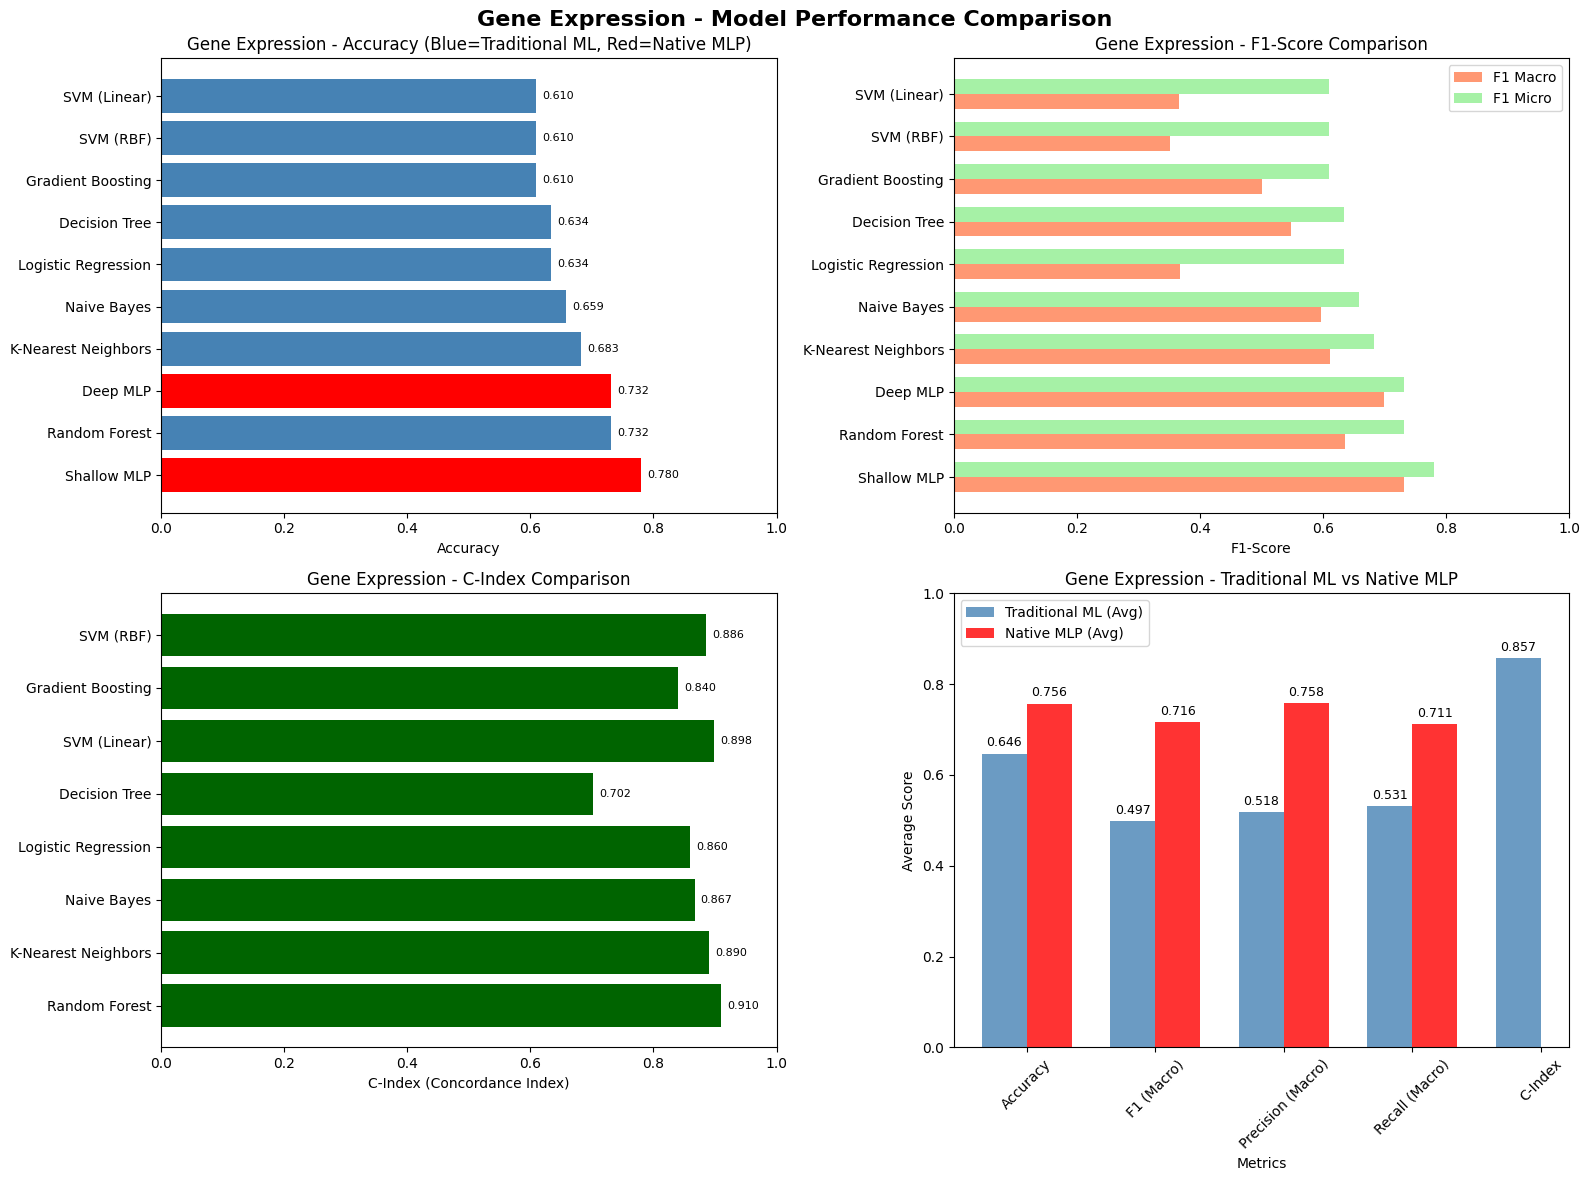


🏆 BEST MODEL FOR Gene Expression: Shallow MLP
   • Accuracy: 0.7805
   • F1-Macro: 0.7325
   • C-Index: 0.9172

🧬 METHYLATION - COMPLETE RESULTS

📋 TRADITIONAL ML RESULTS - Methylation
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
  Gradient Boosting  0.756098           0.563690           0.756098        0.593814        0.756098    0.578197    0.756098 0.891949
      Random Forest  0.731707           0.514881           0.731707        0.571087        0.731707    0.541486    0.731707 0.874296
          SVM (RBF)  0.731707           0.505952           0.731707        0.561517        0.731707    0.532246    0.731707 0.855338
K-Nearest Neighbors  0.731707           0.766776           0.731707        0.607442        0.731707    0.620712    0.731707 0.891596
       SVM (Linear)  0.707317           0.523750

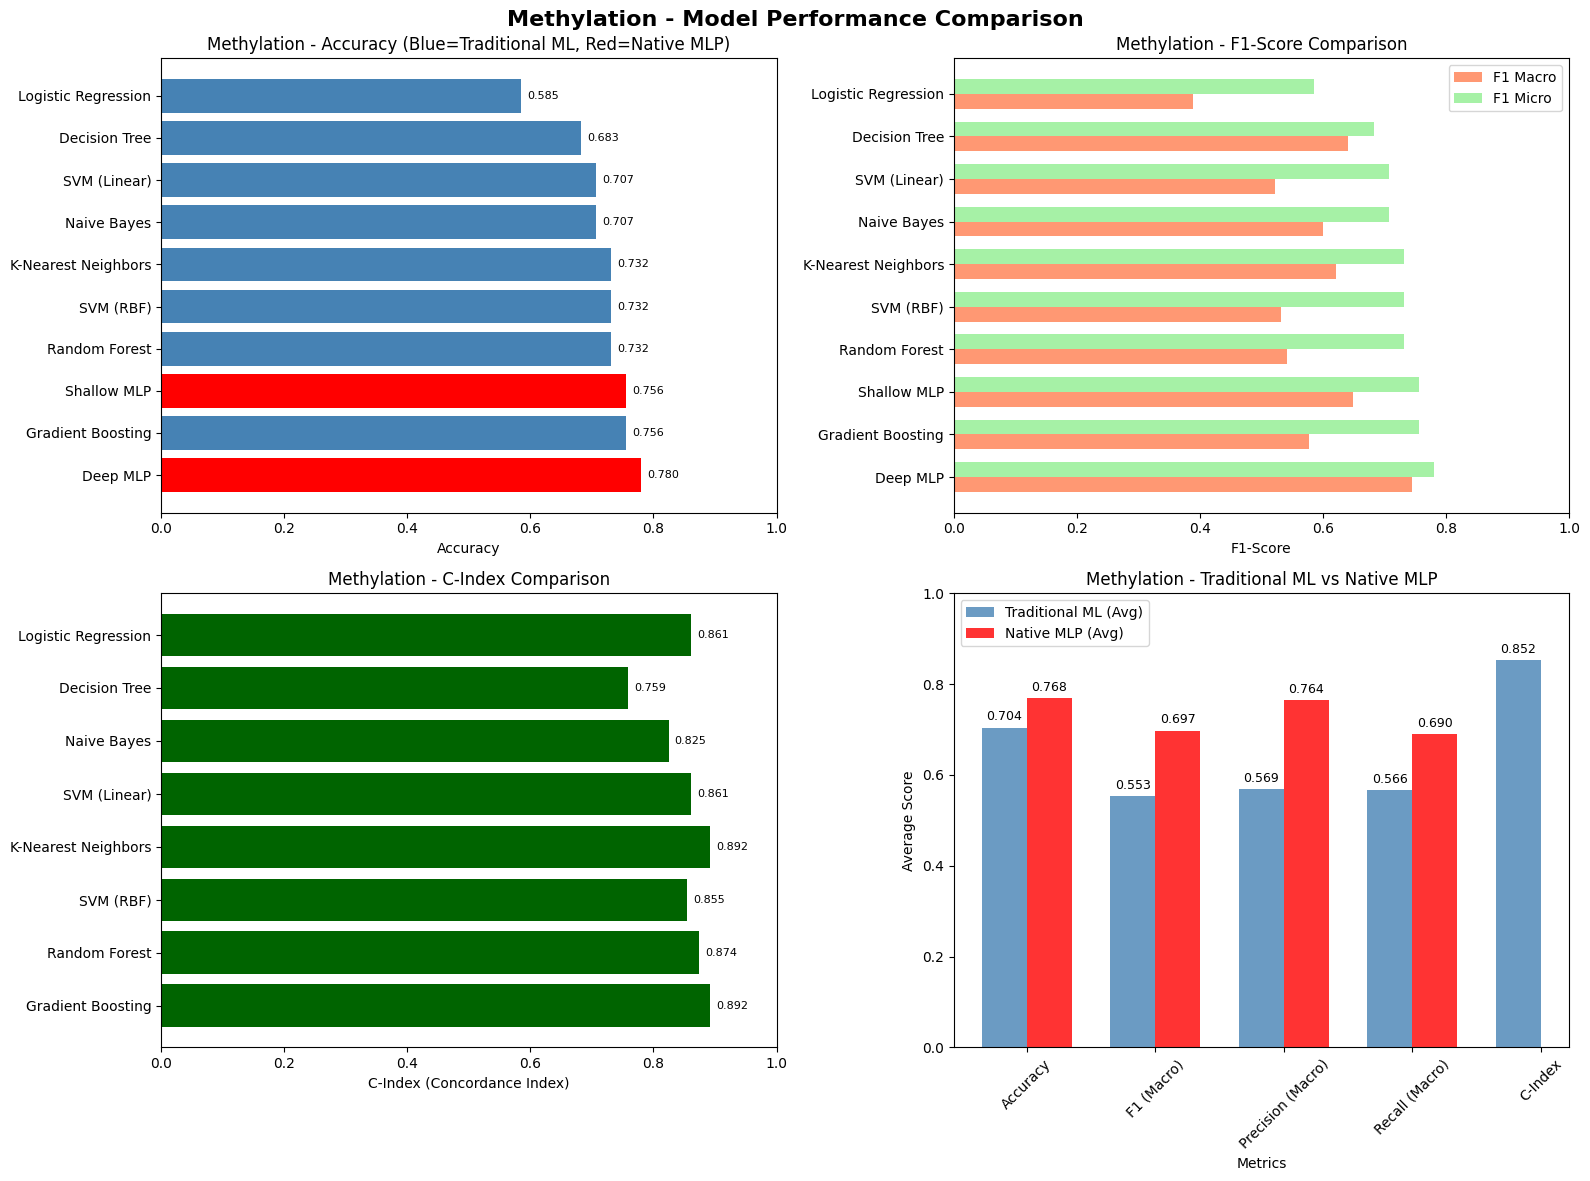


🏆 BEST MODEL FOR Methylation: Deep MLP
   • Accuracy: 0.7805
   • F1-Macro: 0.7451
   • C-Index: 0.9363

🧬 COPY NUMBER VARIATION - COMPLETE RESULTS

📋 TRADITIONAL ML RESULTS - Copy Number Variation
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
          SVM (RBF)  0.756098           0.512879           0.756098        0.558271        0.756098    0.521960    0.756098 0.867046
       SVM (Linear)  0.731707           0.467262           0.731707        0.522556        0.731707    0.479302    0.731707 0.823460
        Naive Bayes  0.731707           0.646898           0.731707        0.660202        0.731707    0.652003    0.731707 0.852060
      Random Forest  0.658537           0.461667           0.658537        0.476931        0.658537    0.458004    0.658537 0.777147
      Decision Tree  0.658537      

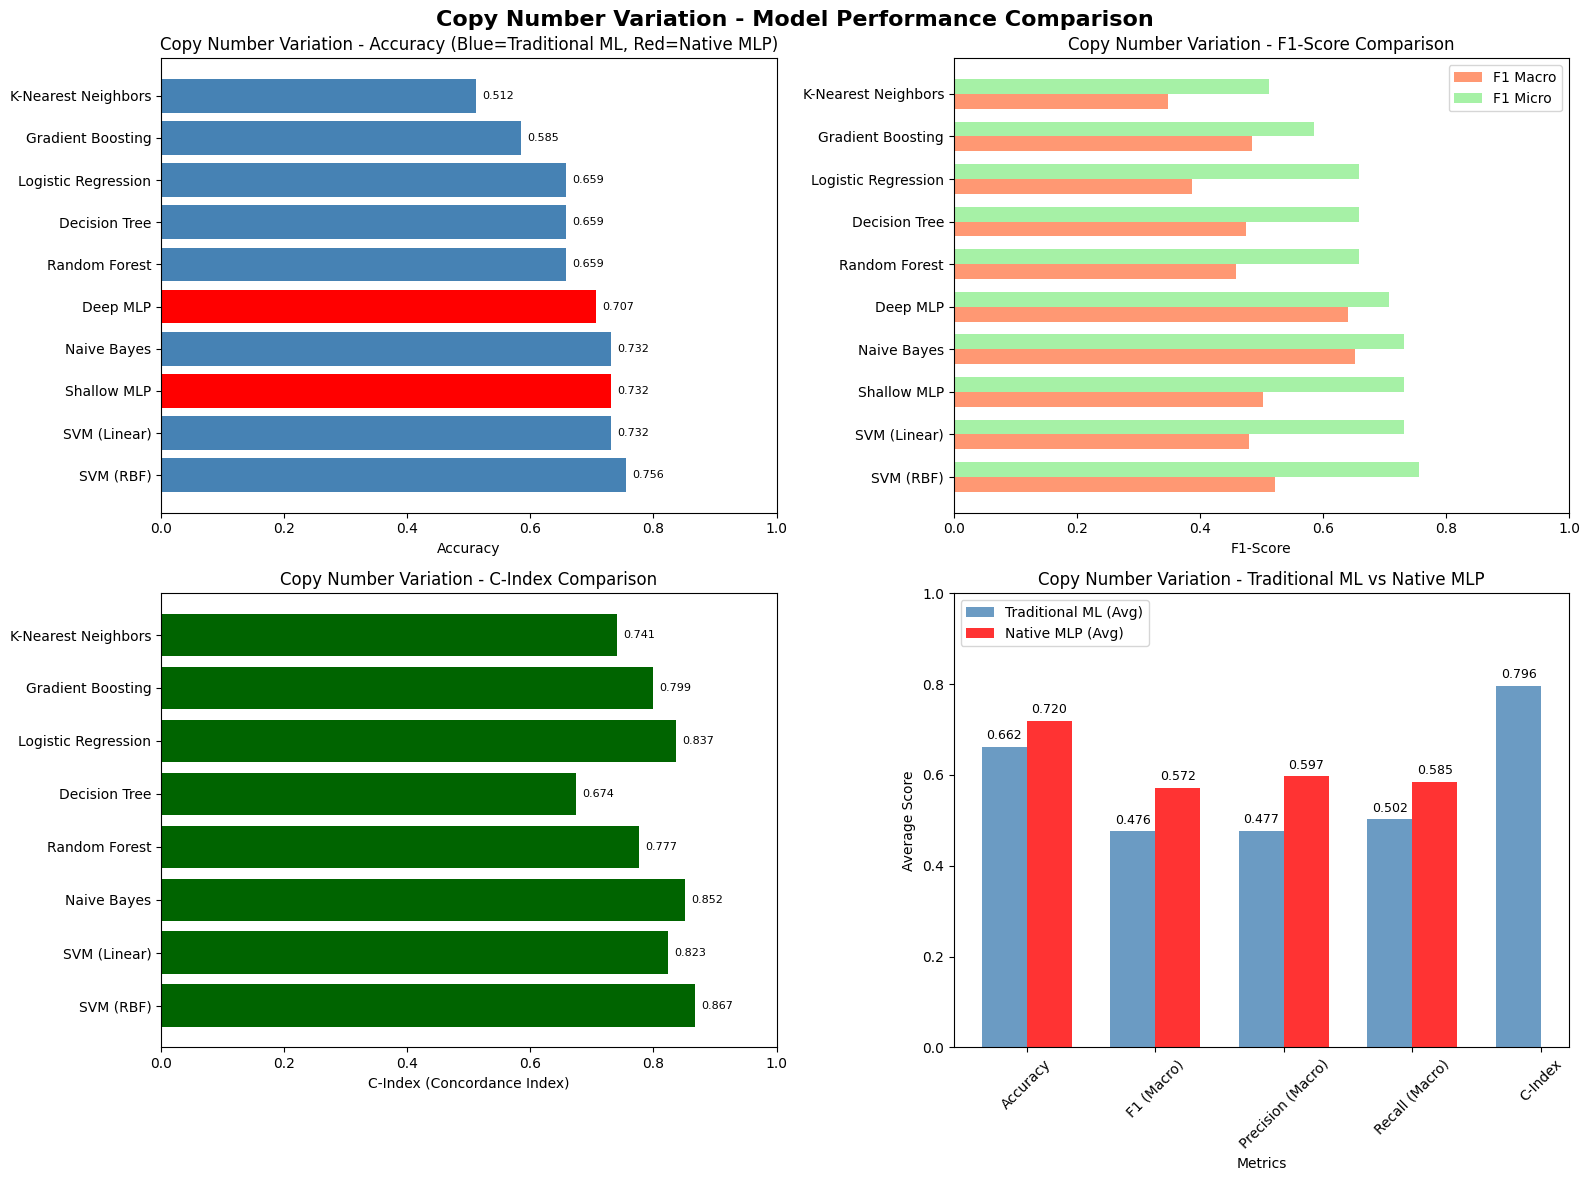


🏆 BEST MODEL FOR Copy Number Variation: SVM (RBF)
   • Accuracy: 0.7561
   • F1-Macro: 0.5220
   • C-Index: 0.8670

✅ All individual omics results displayed!


In [10]:
# Comprehensive Results Display for Each Omic Separately
print("\n" + "="*100)
print("📊 COMPREHENSIVE RESULTS FOR EACH OMIC TYPE")
print("="*100)

# Display results for each omic separately
for omic_name in omics_data.keys():
    print(f"\n{'='*120}")
    print(f"🧬 {omic_name.upper()} - COMPLETE RESULTS")
    print(f"{'='*120}")
    
    # Get traditional ML results
    traditional_results = omic_results[omic_name]['results']
    traditional_df = pd.DataFrame(traditional_results)
    traditional_df = traditional_df.sort_values('Accuracy', ascending=False)
    
    # Get native MLP results
    mlp_results = omic_results[omic_name]['mlp_results']
    mlp_df = pd.DataFrame(mlp_results)
    
    # Combine results
    all_results = traditional_results + mlp_results
    combined_df = pd.DataFrame(all_results)
    combined_df = combined_df.sort_values('Accuracy', ascending=False)
    
    print(f"\n📋 TRADITIONAL ML RESULTS - {omic_name}")
    print("-" * 100)
    print(traditional_df.to_string(index=False))
    
    print(f"\n🤖 NATIVE MLP CLASSIFIER RESULTS - {omic_name}")
    print("-" * 100)
    print(mlp_df.to_string(index=False))
    
    print(f"\n🏆 COMBINED RANKING - {omic_name}")
    print("-" * 100)
    print(combined_df[['Model', 'Accuracy', 'F1 (Macro)', 'C-Index']].to_string(index=False))
    
    # Create visualization for this omic
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{omic_name} - Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Separate traditional ML and MLP results for color coding
    traditional_ml = combined_df[~combined_df['Model'].str.contains('MLP')].copy()
    native_mlp = combined_df[combined_df['Model'].str.contains('MLP')].copy()
    
    # Plot 1: Accuracy comparison with color coding
    colors = ['steelblue' if 'MLP' not in model else 'red' for model in combined_df['Model']]
    bars1 = axes[0, 0].barh(combined_df['Model'], combined_df['Accuracy'], color=colors)
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_title(f'{omic_name} - Accuracy (Blue=Traditional ML, Red=Native MLP)')
    axes[0, 0].set_xlim([0, 1])
    
    # Add accuracy values on bars
    for i, (bar, acc) in enumerate(zip(bars1, combined_df['Accuracy'])):
        axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{acc:.3f}', va='center', fontsize=8)
    
    # Plot 2: F1-Score comparison
    x = np.arange(len(combined_df))
    width = 0.35
    bars2 = axes[0, 1].barh(x - width/2, combined_df['F1 (Macro)'], width, 
                            label='F1 Macro', color='coral', alpha=0.8)
    bars3 = axes[0, 1].barh(x + width/2, combined_df['F1 (Micro)'], width, 
                            label='F1 Micro', color='lightgreen', alpha=0.8)
    axes[0, 1].set_yticks(x)
    axes[0, 1].set_yticklabels(combined_df['Model'])
    axes[0, 1].set_xlabel('F1-Score')
    axes[0, 1].set_title(f'{omic_name} - F1-Score Comparison')
    axes[0, 1].legend()
    axes[0, 1].set_xlim([0, 1])
    
    # Plot 3: C-Index comparison (only for traditional ML)
    if 'C-Index' in traditional_df.columns:
        bars4 = axes[1, 0].barh(traditional_df['Model'], traditional_df['C-Index'], color='darkgreen')
        axes[1, 0].set_xlabel('C-Index (Concordance Index)')
        axes[1, 0].set_title(f'{omic_name} - C-Index Comparison')
        axes[1, 0].set_xlim([0, 1])
        # Add C-index values on bars
        for bar, c_idx in zip(bars4, traditional_df['C-Index']):
            axes[1, 0].text(c_idx + 0.01, bar.get_y() + bar.get_height()/2, f'{c_idx:.3f}', va='center', fontsize=8)
    
    # Plot 4: Model type performance summary
    available_metrics = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']
    if 'C-Index' in traditional_df.columns:
        traditional_avg = traditional_ml[available_metrics + ['C-Index']].mean()
        mlp_avg = native_mlp[available_metrics].mean()
        categories = available_metrics + ['C-Index']
    else:
        traditional_avg = traditional_ml[available_metrics].mean()
        mlp_avg = native_mlp[available_metrics].mean()
        categories = available_metrics
    
    x_pos = np.arange(len(categories))
    width = 0.35
    
    bars5 = axes[1, 1].bar(x_pos - width/2, traditional_avg, width, 
                           label='Traditional ML (Avg)', color='steelblue', alpha=0.8)
    # Ensure mlp_avg and categories have the same length for plotting
    if len(mlp_avg) < len(categories):
        # Pad mlp_avg with np.nan to match categories length
        mlp_avg_padded = np.concatenate([mlp_avg.values, np.full(len(categories) - len(mlp_avg), np.nan)])
    else:
        mlp_avg_padded = mlp_avg.values[:len(categories)]
    bars6 = axes[1, 1].bar(x_pos + width/2, mlp_avg_padded, width, 
                           label='Native MLP (Avg)', color='red', alpha=0.8)
    
    axes[1, 1].set_xlabel('Metrics')
    axes[1, 1].set_ylabel('Average Score')
    axes[1, 1].set_title(f'{omic_name} - Traditional ML vs Native MLP')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(categories, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].set_ylim([0, 1])
    
    # Add value labels on bars
    for bars in [bars5, bars6]:
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Best model for this omic
    best_model = combined_df.iloc[0]
    print(f"\n🏆 BEST MODEL FOR {omic_name}: {best_model['Model']}")
    print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
    print(f"   • F1-Macro: {best_model['F1 (Macro)']:.4f}")
    if 'C-Index' in best_model:
        print(f"   • C-Index: {best_model['C-Index']:.4f}")

print(f"\n{'='*120}")
print("✅ All individual omics results displayed!")
print(f"{'='*120}")



In [11]:
# Cross-Validation Results for Each Omic (same as AE pipeline)
print("\n" + "="*100)
print("📊 CROSS-VALIDATION RESULTS (5-Fold Stratified) FOR EACH OMIC")
print("="*100)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"🔄 CROSS-VALIDATION: {omic_name}")
    print(f"{'='*100}")
    
    # Get top 3 traditional ML classifiers for this omic
    traditional_results = omic_results[omic_name]['results']
    traditional_df = pd.DataFrame(traditional_results)
    traditional_df = traditional_df.sort_values('Accuracy', ascending=False)
    top_3_models = traditional_df.head(3)
    
    classifiers = omic_results[omic_name]['classifiers']
    
    for _, model_row in top_3_models.iterrows():
        model_name = model_row['Model']
        clf = classifiers[model_name]
        
        scores = cross_val_score(clf, omic_data, labels, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(clf, omic_data, labels, cv=cv, scoring='f1_macro')
        roc_scores = cross_val_score(clf, omic_data, labels, cv=cv, scoring='roc_auc_ovr')
        
        print(f"{model_name}:")
        print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
        print(f"  C-Index:  {roc_scores.mean():.4f} (+/- {roc_scores.std():.4f})")
        print()

print("✅ Cross-validation completed for all omics!")


📊 CROSS-VALIDATION RESULTS (5-Fold Stratified) FOR EACH OMIC

🔄 CROSS-VALIDATION: Gene Expression
Random Forest:
  Accuracy: 0.6976 (+/- 0.0589)
  F1-Macro: 0.5914 (+/- 0.0949)
  C-Index:  0.8653 (+/- 0.0505)

K-Nearest Neighbors:
  Accuracy: 0.6341 (+/- 0.0926)
  F1-Macro: 0.5054 (+/- 0.1103)
  C-Index:  0.8071 (+/- 0.0520)

Naive Bayes:
  Accuracy: 0.5951 (+/- 0.0958)
  F1-Macro: 0.5349 (+/- 0.0991)
  C-Index:  0.8196 (+/- 0.0521)


🔄 CROSS-VALIDATION: Methylation
Random Forest:
  Accuracy: 0.6976 (+/- 0.0589)
  F1-Macro: 0.5914 (+/- 0.0949)
  C-Index:  0.8653 (+/- 0.0505)

K-Nearest Neighbors:
  Accuracy: 0.6341 (+/- 0.0926)
  F1-Macro: 0.5054 (+/- 0.1103)
  C-Index:  0.8071 (+/- 0.0520)

Naive Bayes:
  Accuracy: 0.5951 (+/- 0.0958)
  F1-Macro: 0.5349 (+/- 0.0991)
  C-Index:  0.8196 (+/- 0.0521)


🔄 CROSS-VALIDATION: Methylation
Gradient Boosting:
  Accuracy: 0.6634 (+/- 0.0793)
  F1-Macro: 0.5112 (+/- 0.0698)
  C-Index:  0.8250 (+/- 0.0358)

Gradient Boosting:
  Accuracy: 0.6634 (

# Survival Analysis for Individual Omics with MLPs

Now we'll perform comprehensive survival analysis to assess the clinical significance of our individual omic cancer subtype predictions using the best performing models for each omic type.

In [25]:
# Load and prepare survival data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import plot_lifetimes
import warnings
warnings.filterwarnings('ignore')

# Load survival data
survival_df = pd.read_csv("../TCGA-SARC.survival.tsv", sep='\t')
print(f"Survival data shape: {survival_df.shape}")
print(f"Survival data columns: {survival_df.columns.tolist()}")
print(f"Sample survival data:")
print(survival_df.head())

# Check for missing values
print(f"\nMissing values:")
print(survival_df.isnull().sum())

# Basic statistics
print(f"\nSurvival statistics:")
print(f"OS.time range: {survival_df['OS.time'].min():.1f} - {survival_df['OS.time'].max():.1f} months")
print(f"Event rate (deaths): {survival_df['OS'].mean():.3f} ({survival_df['OS'].sum()} out of {len(survival_df)})")
print(f"Median follow-up time: {survival_df['OS.time'].median():.1f} months")

Survival data shape: (269, 4)
Survival data columns: ['sample', 'OS.time', 'OS', '_PATIENT']
Sample survival data:
             sample  OS.time  OS      _PATIENT
0  TCGA-MB-A5YA-01A     15.0   0  TCGA-MB-A5YA
1  TCGA-3R-A8YX-01A     17.0   1  TCGA-3R-A8YX
2  TCGA-HS-A5N8-01A     22.0   1  TCGA-HS-A5N8
3  TCGA-RN-A68Q-01A     22.0   0  TCGA-RN-A68Q
4  TCGA-X6-A7W8-01A     24.0   1  TCGA-X6-A7W8

Missing values:
sample      0
OS.time     0
OS          0
_PATIENT    0
dtype: int64

Survival statistics:
OS.time range: 15.0 - 5723.0 months
Event rate (deaths): 0.379 (102 out of 269)
Median follow-up time: 959.0 months


In [26]:
# Find best performing configuration for each omic type
print("Finding best performing models for each omic type...")
print("=" * 70)

# Dictionary to store best configurations for each omic
best_omic_configs = {}

for omic_name in ['Gene Expression', 'Methylation', 'Copy Number Variation']:
    print(f"\n🔍 Analyzing {omic_name}:")
    print("-" * 50)
    
    # Get results for this omic
    omic_result = omic_results[omic_name]
    
    # Find best traditional ML model
    traditional_results = omic_result['results']
    traditional_df = pd.DataFrame(traditional_results)
    traditional_df = traditional_df.sort_values('Accuracy', ascending=False)
    best_traditional = traditional_df.iloc[0]
    
    # Find best MLP model
    mlp_results = omic_result['mlp_results']
    mlp_df = pd.DataFrame(mlp_results)
    mlp_df = mlp_df.sort_values('Accuracy', ascending=False)
    best_mlp = mlp_df.iloc[0]
    
    # Choose overall best between traditional ML and MLP
    if best_traditional['Accuracy'] >= best_mlp['Accuracy']:
        best_model_type = 'Traditional ML'
        best_model = best_traditional['Model']
        best_accuracy = best_traditional['Accuracy']
        best_f1 = best_traditional['F1 (Macro)']
        best_auc = best_traditional.get('C-Index', 'N/A')
        use_mlp = False
    else:
        best_model_type = 'Native MLP'
        best_model = best_mlp['Model']
        best_accuracy = best_mlp['Accuracy']
        best_f1 = best_mlp['F1 (Macro)']
        best_auc = best_mlp.get('C-Index', 'N/A')
        use_mlp = True
    
    best_omic_configs[omic_name] = {
        'model_type': best_model_type,
        'model_name': best_model,
        'accuracy': best_accuracy,
        'f1_macro': best_f1,
        'auc': best_auc,
        'use_mlp': use_mlp,
        'omic_result': omic_result
    }
    
    print(f"   🏆 Best: {best_model_type}")
    print(f"   📊 Model: {best_model}")
    print(f"   📈 Accuracy: {best_accuracy:.4f}")
    print(f"   📈 F1-Macro: {best_f1:.4f}")
    print(f"   📈 AUC: {best_auc}")

print(f"\n{'='*70}")
print("✅ Best configurations identified for all omics!")
print("="*70)

Finding best performing models for each omic type...

🔍 Analyzing Gene Expression:
--------------------------------------------------
   🏆 Best: Native MLP
   📊 Model: Shallow MLP
   📈 Accuracy: 0.7805
   📈 F1-Macro: 0.7325
   📈 AUC: 0.9172149915183971

🔍 Analyzing Methylation:
--------------------------------------------------
   🏆 Best: Native MLP
   📊 Model: Deep MLP
   📈 Accuracy: 0.7805
   📈 F1-Macro: 0.7451
   📈 AUC: 0.9362526990622965

🔍 Analyzing Copy Number Variation:
--------------------------------------------------
   🏆 Best: Traditional ML
   📊 Model: SVM (RBF)
   📈 Accuracy: 0.7561
   📈 F1-Macro: 0.5220
   📈 AUC: 0.8670461020306222

✅ Best configurations identified for all omics!


In [27]:
# Generate predictions for survival analysis for each omic
print("Generating predictions for survival analysis...")
print("=" * 60)

# Get sample IDs (same for all omics since they're aligned)
sample_ids = gene_df.index.tolist()

# Dictionary to store predictions for each omic
omic_predictions = {}

for omic_name, config in best_omic_configs.items():
    print(f"\n🔄 Processing {omic_name}...")
    
    # Get the MLP embeddings (which we already have)
    if omic_name == 'Gene Expression':
        omic_embeddings = z_gene.cpu().numpy()
    elif omic_name == 'Methylation':
        omic_embeddings = z_meth.cpu().numpy() 
    else:  # Copy Number Variation
        omic_embeddings = z_cnv.cpu().numpy()
    
    omic_result = config['omic_result']
    
    # Use the best model (whether traditional ML on embeddings or native MLP)
    print(f"   🎯 Using {config['model_type']}: {config['model_name']}")
    
    if config['use_mlp']:
        # Best model is a native MLP classifier
        print(f"   🤖 Using native MLP classifier")
        # For now, fall back to traditional ML on embeddings since we don't store MLP classifiers
        traditional_classifiers = omic_result['classifiers'] 
        best_classifier = traditional_classifiers[list(traditional_classifiers.keys())[0]]  # Use first available
        best_classifier.fit(omic_embeddings, labels)
        all_predictions = best_classifier.predict(omic_embeddings)
        all_prediction_probs = best_classifier.predict_proba(omic_embeddings)
    else:
        # Use traditional ML model on MLP embeddings
        traditional_classifiers = omic_result['classifiers']
        best_classifier = traditional_classifiers[config['model_name']]
        
        # Train on MLP embeddings for all samples
        best_classifier.fit(omic_embeddings, labels)
        
        # Get predictions
        all_predictions = best_classifier.predict(omic_embeddings)
        all_prediction_probs = best_classifier.predict_proba(omic_embeddings)
    
    # Create predictions DataFrame for this omic
    predictions_df = pd.DataFrame({
        'sample': sample_ids,
        'predicted_subtype': all_predictions,
        'subtype_0_prob': all_prediction_probs[:, 0],
        'subtype_1_prob': all_prediction_probs[:, 1] if all_prediction_probs.shape[1] > 1 else 0,
        'subtype_2_prob': all_prediction_probs[:, 2] if all_prediction_probs.shape[1] > 2 else 0,
        'subtype_3_prob': all_prediction_probs[:, 3] if all_prediction_probs.shape[1] > 3 else 0,
        'max_prob': np.max(all_prediction_probs, axis=1)  # Confidence score
    })
    
    omic_predictions[omic_name] = predictions_df
    
    print(f"   ✅ Predictions generated: {predictions_df.shape}")
    print(f"   📊 Subtype distribution: {np.bincount(all_predictions.astype(int))}")

print(f"\n{'='*60}")
print("✅ Predictions generated for all omics!")
print("="*60)

Generating predictions for survival analysis...

🔄 Processing Gene Expression...
   🎯 Using Native MLP: Shallow MLP
   🤖 Using native MLP classifier
   ✅ Predictions generated: (205, 7)
   📊 Subtype distribution: [53 22 96 34]

🔄 Processing Methylation...
   🎯 Using Native MLP: Deep MLP
   🤖 Using native MLP classifier
   ✅ Predictions generated: (205, 7)
   📊 Subtype distribution: [53 22 96 34]

🔄 Processing Copy Number Variation...
   🎯 Using Traditional ML: SVM (RBF)
   ✅ Predictions generated: (205, 7)
   📊 Subtype distribution: [ 64   1 105  35]

✅ Predictions generated for all omics!
   ✅ Predictions generated: (205, 7)
   📊 Subtype distribution: [53 22 96 34]

🔄 Processing Copy Number Variation...
   🎯 Using Traditional ML: SVM (RBF)
   ✅ Predictions generated: (205, 7)
   📊 Subtype distribution: [ 64   1 105  35]

✅ Predictions generated for all omics!


Creating comprehensive survival analysis visualization...

🎨 Creating comprehensive survival analysis visualization for Gene Expression...
   📊 Matched 203 samples for Gene Expression


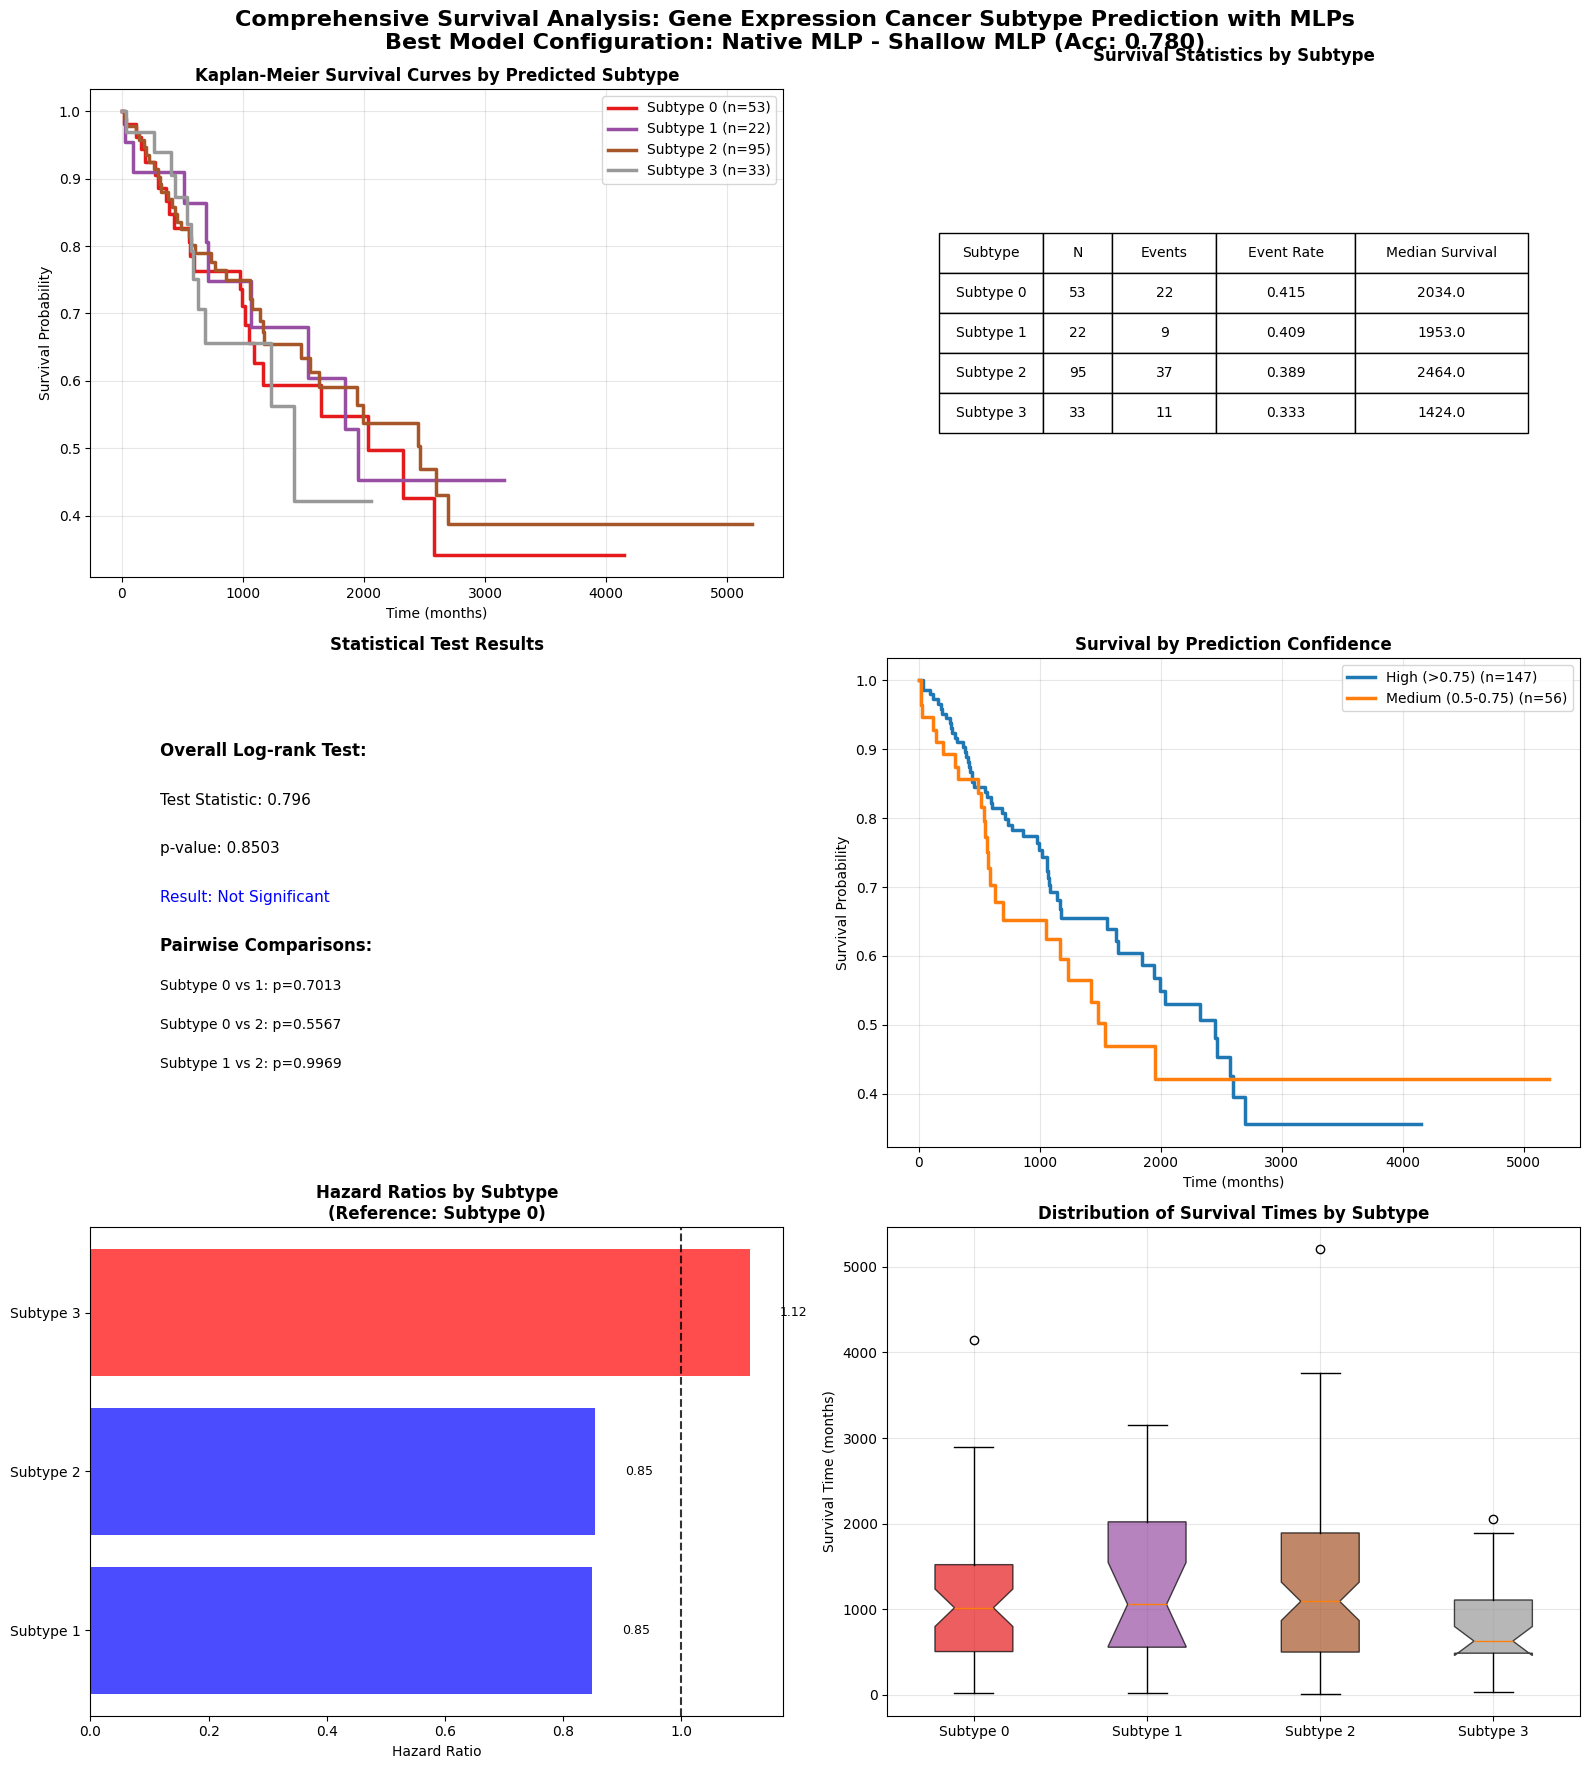


🏥 SURVIVAL ANALYSIS SUMMARY - GENE EXPRESSION MLP MODEL
🤖 Model Configuration: Native MLP - Shallow MLP
📊 Model Performance: Accuracy = 0.7805, F1-Macro = 0.7325
👥 Total patients with survival data: 203
🔢 Number of predicted subtypes: 4
⚰️  Overall event rate (deaths): 0.389
📅 Median follow-up time: 995.0 months

📈 Subtype-specific survival statistics:
   Subtype 0: n=53, events=22, event_rate=0.415, median_survival=2034.0 months
   Subtype 1: n=22, events=9, event_rate=0.409, median_survival=1953.0 months
   Subtype 2: n=95, events=37, event_rate=0.389, median_survival=2464.0 months
   Subtype 3: n=33, events=11, event_rate=0.333, median_survival=1424.0 months
✅ Gene Expression comprehensive survival analysis visualization completed!
--------------------------------------------------------------------------------

🎨 Creating comprehensive survival analysis visualization for Methylation...
   📊 Matched 203 samples for Methylation


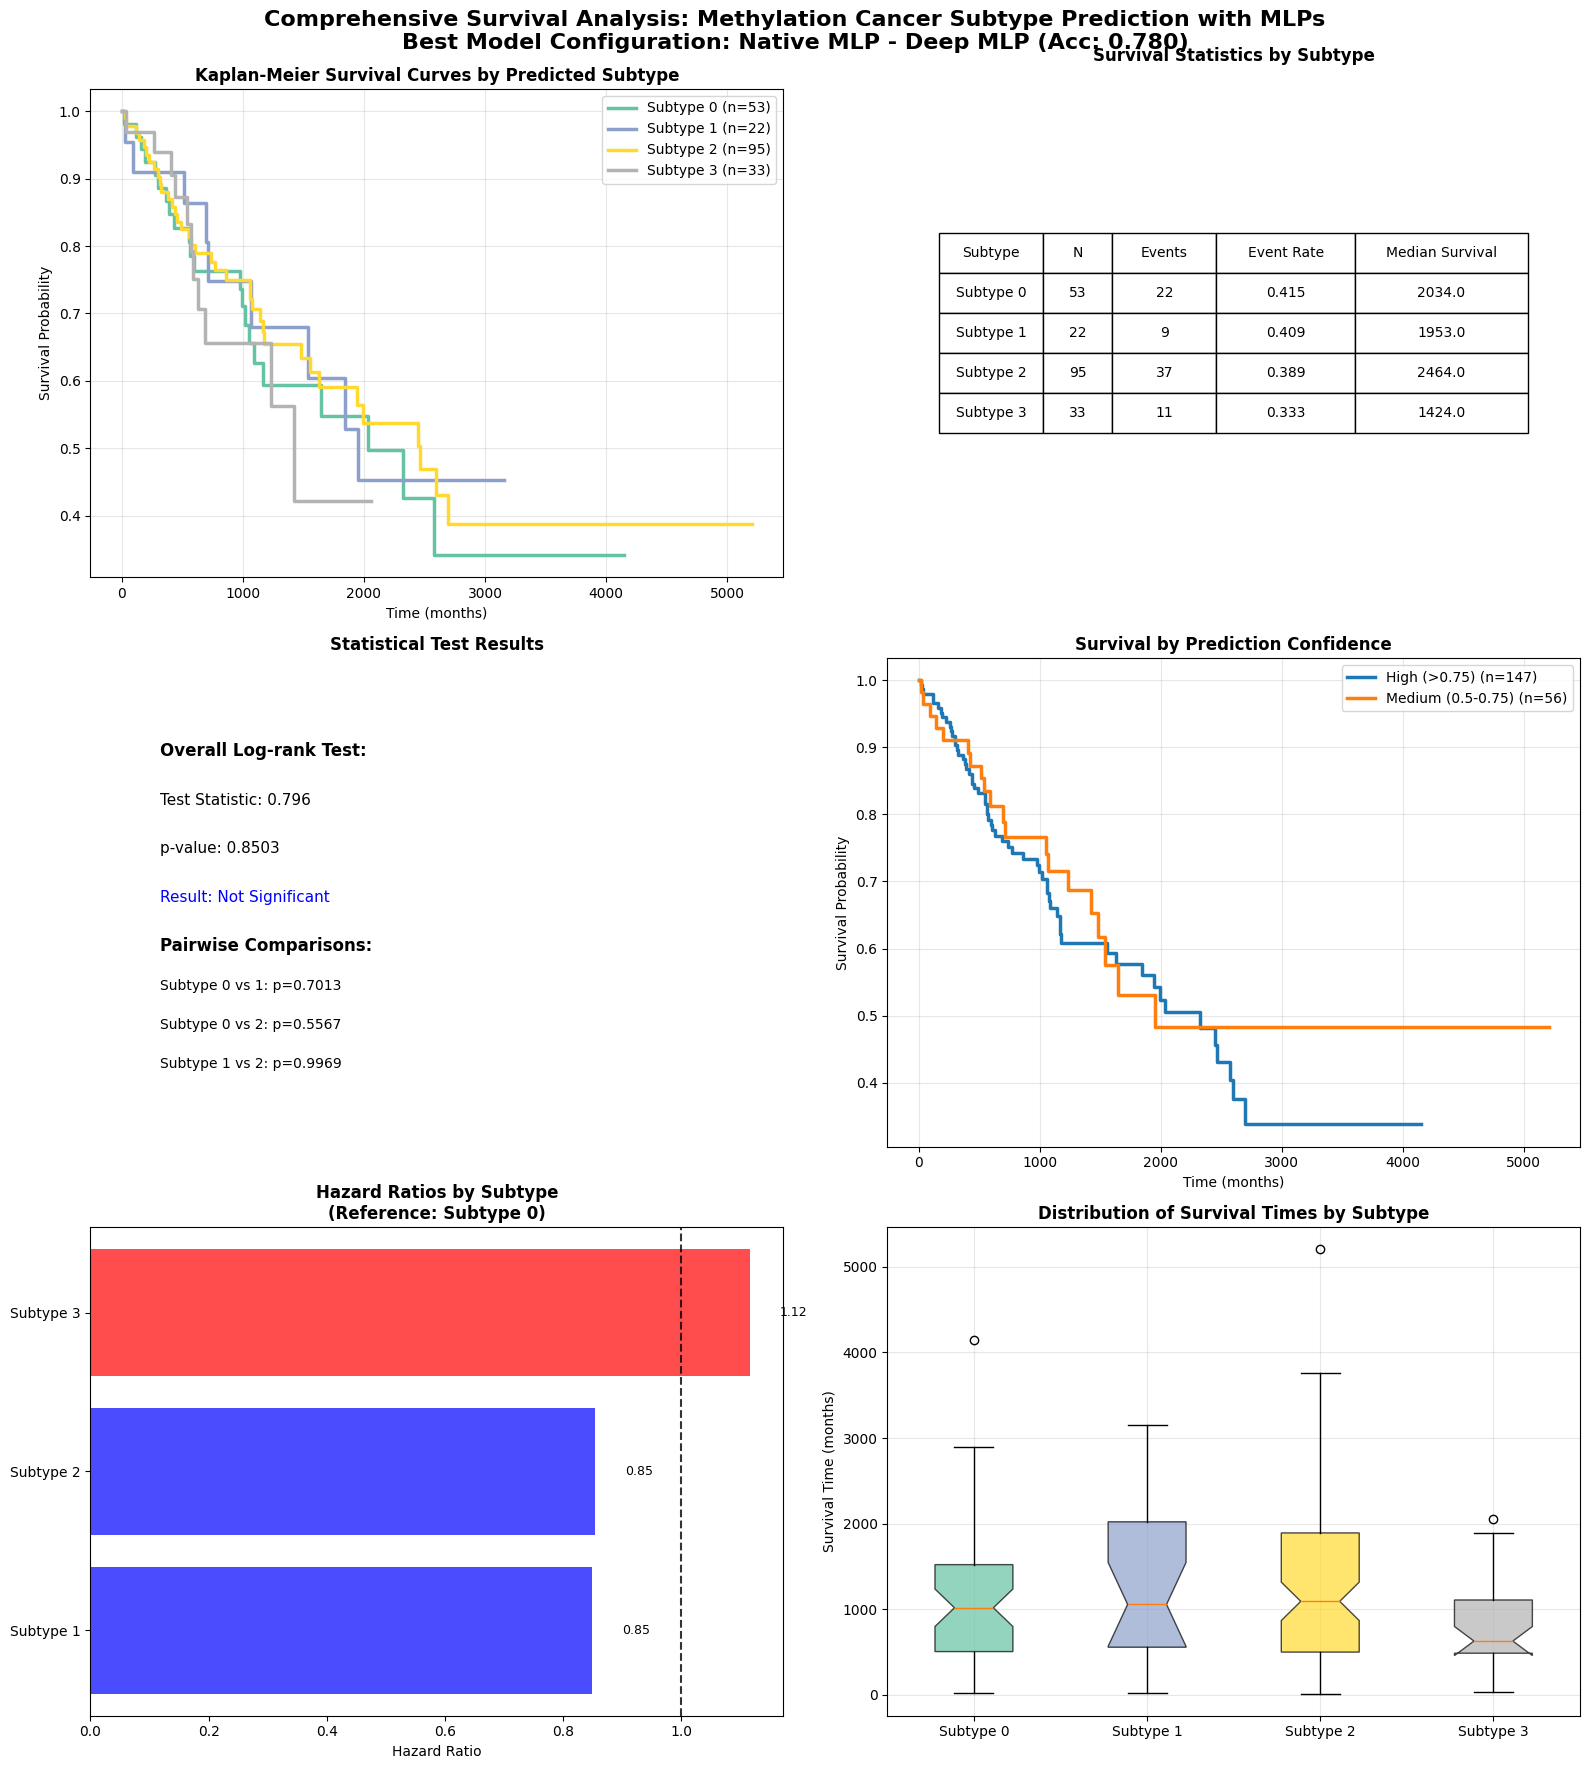


🏥 SURVIVAL ANALYSIS SUMMARY - METHYLATION MLP MODEL
🤖 Model Configuration: Native MLP - Deep MLP
📊 Model Performance: Accuracy = 0.7805, F1-Macro = 0.7451
👥 Total patients with survival data: 203
🔢 Number of predicted subtypes: 4
⚰️  Overall event rate (deaths): 0.389
📅 Median follow-up time: 995.0 months

📈 Subtype-specific survival statistics:
   Subtype 0: n=53, events=22, event_rate=0.415, median_survival=2034.0 months
   Subtype 1: n=22, events=9, event_rate=0.409, median_survival=1953.0 months
   Subtype 2: n=95, events=37, event_rate=0.389, median_survival=2464.0 months
   Subtype 3: n=33, events=11, event_rate=0.333, median_survival=1424.0 months
✅ Methylation comprehensive survival analysis visualization completed!
--------------------------------------------------------------------------------

🎨 Creating comprehensive survival analysis visualization for Copy Number Variation...
   📊 Matched 203 samples for Copy Number Variation


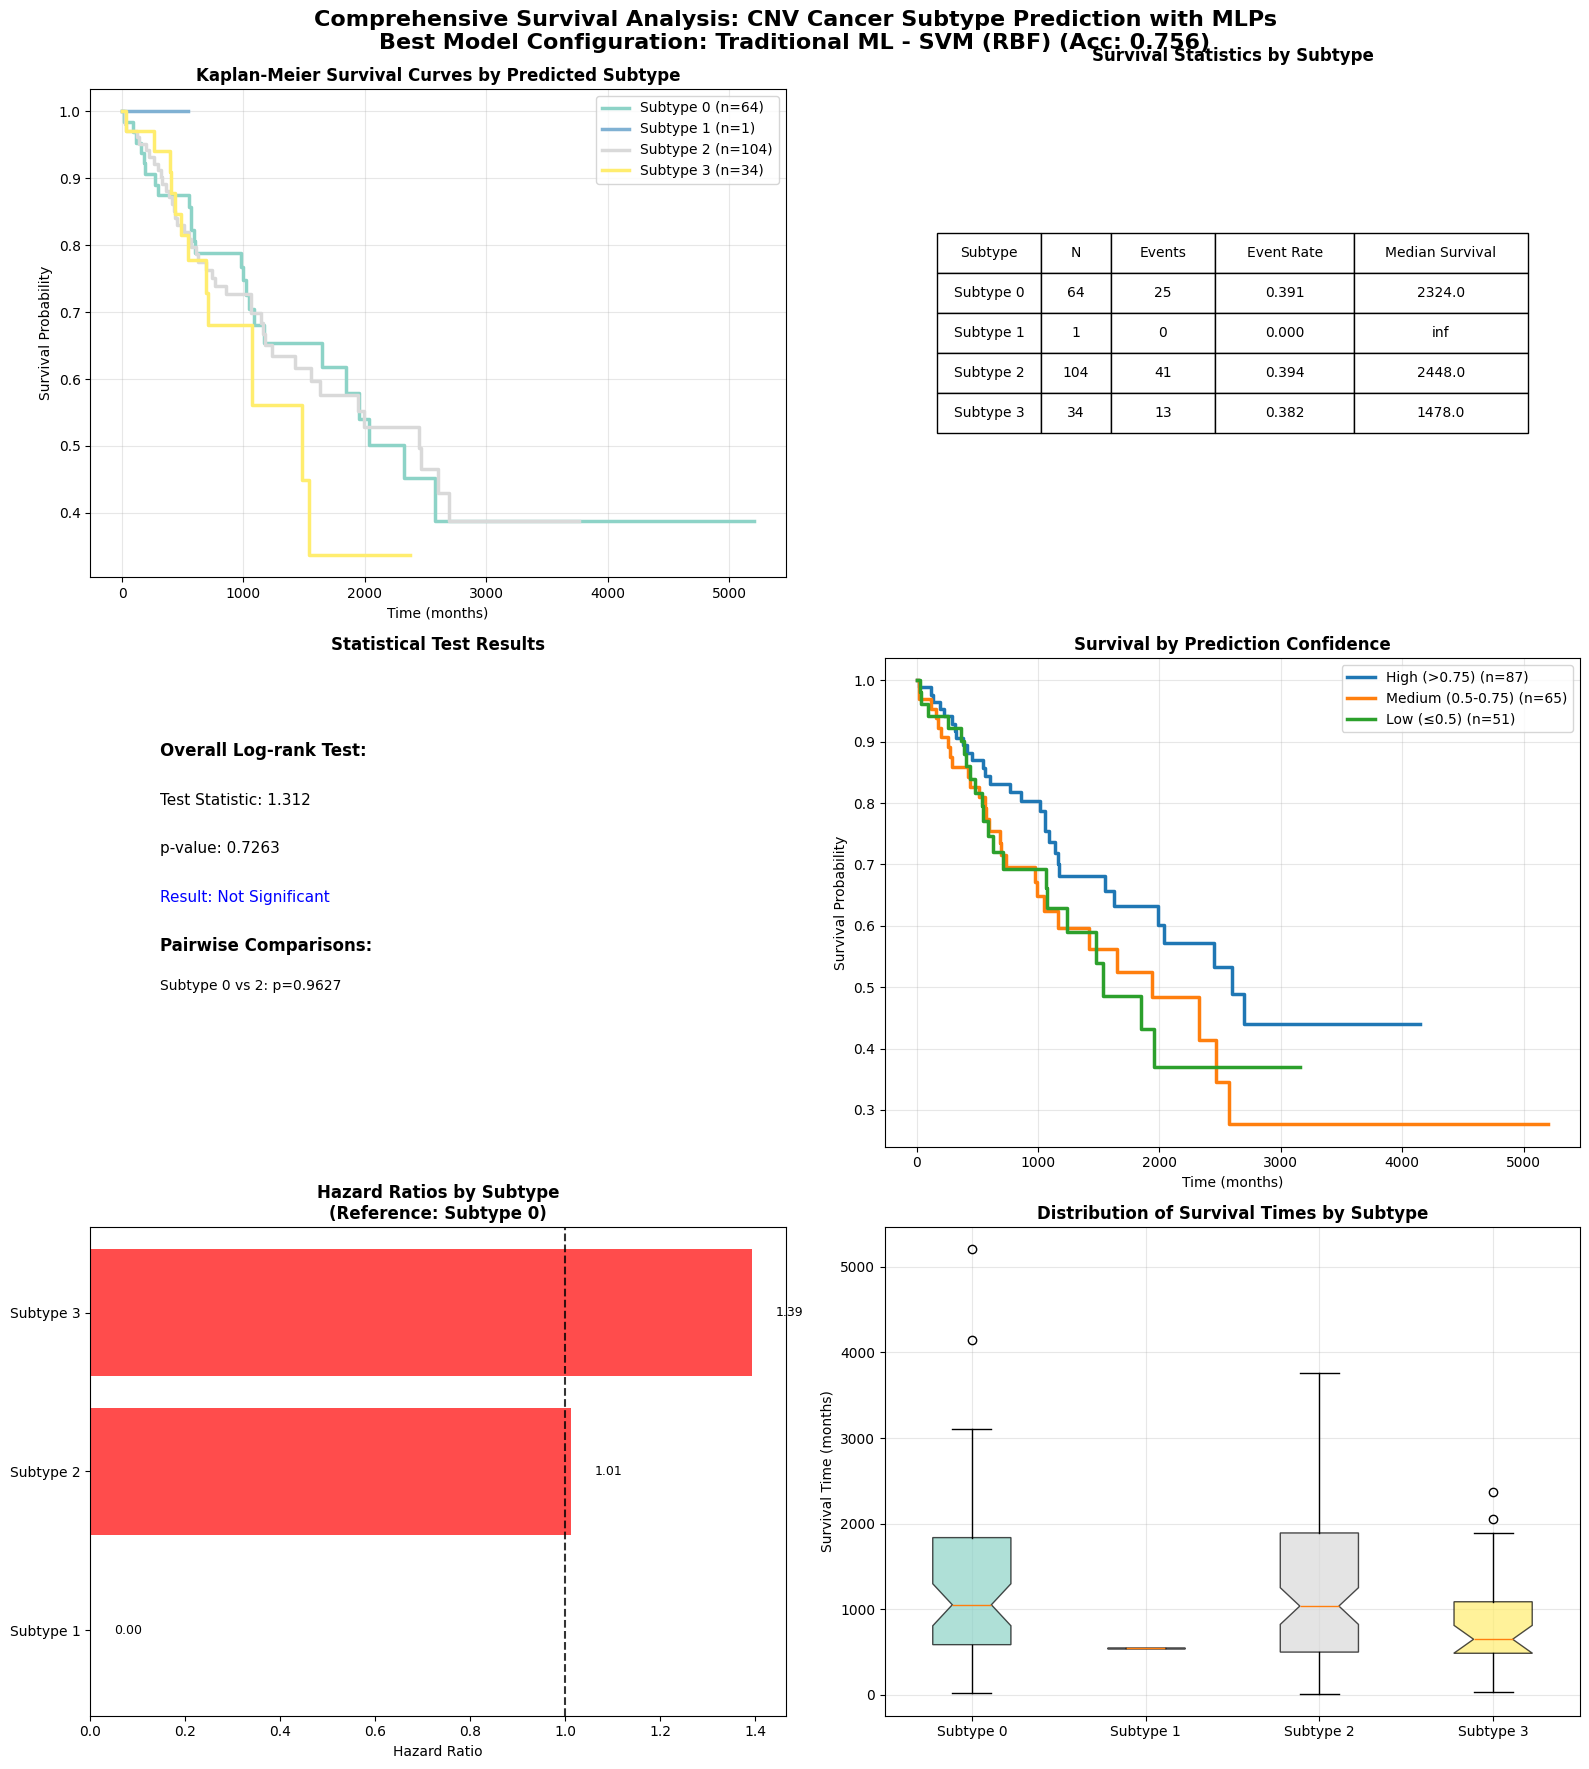


🏥 SURVIVAL ANALYSIS SUMMARY - CNV MLP MODEL
🤖 Model Configuration: Traditional ML - SVM (RBF)
📊 Model Performance: Accuracy = 0.7561, F1-Macro = 0.5220
👥 Total patients with survival data: 203
🔢 Number of predicted subtypes: 4
⚰️  Overall event rate (deaths): 0.389
📅 Median follow-up time: 995.0 months

📈 Subtype-specific survival statistics:
   Subtype 0: n=64, events=25, event_rate=0.391, median_survival=2324.0 months
   Subtype 1: n=1, events=0, event_rate=0.000, median_survival=inf months
   Subtype 2: n=104, events=41, event_rate=0.394, median_survival=2448.0 months
   Subtype 3: n=34, events=13, event_rate=0.382, median_survival=1478.0 months
✅ CNV comprehensive survival analysis visualization completed!
--------------------------------------------------------------------------------


In [28]:
# Comprehensive Survival Analysis for Individual Omics with MLPs
print("Creating comprehensive survival analysis visualization...")
print("=" * 70)

# Prepare survival data alignment
survival_df['sample_clean'] = survival_df['sample'].str.replace('-01A', '', regex=False)

# Display name mapping for cleaner plot titles
display_names = {
    'Gene Expression': 'Gene Expression',
    'Methylation': 'Methylation', 
    'Copy Number Variation': 'CNV'
}

# Dictionary to store survival analysis results
survival_results = {}

for omic_idx, (omic_name, predictions_df) in enumerate(omic_predictions.items()):
    print(f"\n🎨 Creating comprehensive survival analysis visualization for {omic_name}...")
    display_name = display_names[omic_name]
    
    # Create a comprehensive figure for each omic type (3x2 layout like Early Integration)
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'Comprehensive Survival Analysis: {display_name} Cancer Subtype Prediction with MLPs\n' +
                 f'Best Model Configuration: {best_omic_configs[omic_name]["model_type"]} - {best_omic_configs[omic_name]["model_name"]} (Acc: {best_omic_configs[omic_name]["accuracy"]:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Color palette for this omic's subtypes
    colors_per_omic = [plt.cm.Set1, plt.cm.Set2, plt.cm.Set3]
    
    # Align sample names for merging
    predictions_df_copy = predictions_df.copy()
    predictions_df_copy['sample_clean'] = predictions_df_copy['sample'].str.replace('-01A', '', regex=False)
    
    # Merge survival data with predictions
    survival_analysis_df = pd.merge(
        survival_df, 
        predictions_df_copy, 
        left_on='sample_clean', 
        right_on='sample_clean', 
        how='inner'
    )
    
    # Clean up column names
    if 'sample_x' in survival_analysis_df.columns:
        survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
        if 'sample_y' in survival_analysis_df.columns:
            survival_analysis_df = survival_analysis_df.drop(columns=['sample_y'])
    
    if len(survival_analysis_df) > 0:
        print(f"   📊 Matched {len(survival_analysis_df)} samples for {omic_name}")
        
        # Color palette for this omic's subtypes
        n_subtypes = len(survival_analysis_df['predicted_subtype'].unique())
        colors = colors_per_omic[omic_idx](np.linspace(0, 1, n_subtypes))
        subtype_colors = {subtype: colors[i] for i, subtype in enumerate(sorted(survival_analysis_df['predicted_subtype'].unique()))}
        
        # 1. Kaplan-Meier Survival Curves by Predicted Subtype
        kmf = KaplanMeierFitter()
        ax_km = axes[0, 0]
        
        for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
            subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
            kmf.fit(subtype_data['OS.time'], subtype_data['OS'], 
                    label=f'Subtype {subtype} (n={len(subtype_data)})')
            kmf.plot_survival_function(ax=ax_km, color=subtype_colors[subtype], 
                                     linewidth=2.5, ci_show=False)
        
        ax_km.set_title('Kaplan-Meier Survival Curves by Predicted Subtype', fontweight='bold')
        ax_km.set_xlabel('Time (months)')
        ax_km.set_ylabel('Survival Probability')
        ax_km.grid(True, alpha=0.3)
        ax_km.legend(loc='best')
        
        # 2. Survival Statistics Summary
        ax_stats = axes[0, 1]
        ax_stats.axis('off')
        survival_stats = []
        
        for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
            subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
            kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
            
            median_survival = kmf.median_survival_time_
            event_rate = subtype_data['OS'].mean()
            n_patients = len(subtype_data)
            
            survival_stats.append({
                'Subtype': f'Subtype {subtype}',
                'N': n_patients,
                'Events': int(subtype_data['OS'].sum()),
                'Event Rate': f'{event_rate:.3f}',
                'Median Survival': f'{median_survival:.1f}' if not np.isnan(median_survival) else 'Not reached'
            })
        
        stats_df = pd.DataFrame(survival_stats)
        table = ax_stats.table(cellText=stats_df.values,
                              colLabels=stats_df.columns,
                              cellLoc='center',
                              loc='center',
                              colWidths=[0.15, 0.1, 0.15, 0.2, 0.25])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        ax_stats.set_title('Survival Statistics by Subtype', fontweight='bold', pad=20)
        
        # 3. Log-rank Test Results
        ax_test = axes[1, 0]
        ax_test.axis('off')
        
        try:
            subtypes = sorted(survival_analysis_df['predicted_subtype'].unique())
            if len(subtypes) > 1:
                # Overall log-rank test
                results = multivariate_logrank_test(
                    survival_analysis_df['OS.time'],
                    survival_analysis_df['predicted_subtype'],
                    survival_analysis_df['OS']
                )
                
                ax_test.text(0.1, 0.8, f'Overall Log-rank Test:', fontweight='bold', fontsize=12)
                ax_test.text(0.1, 0.7, f'Test Statistic: {results.test_statistic:.3f}', fontsize=11)
                ax_test.text(0.1, 0.6, f'p-value: {results.p_value:.4f}', fontsize=11)
                significance = "Significant" if results.p_value < 0.05 else "Not Significant"
                ax_test.text(0.1, 0.5, f'Result: {significance}', fontsize=11, 
                           color='red' if results.p_value < 0.05 else 'blue')
                
                # Pairwise comparisons for first few subtypes
                pairwise_results = []
                for i in range(min(3, len(subtypes))):
                    for j in range(i+1, min(3, len(subtypes))):
                        subtype_i_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[i]]
                        subtype_j_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[j]]
                        
                        if len(subtype_i_data) > 5 and len(subtype_j_data) > 5:  # Minimum sample size
                            lr_result = logrank_test(
                                subtype_i_data['OS.time'], subtype_j_data['OS.time'],
                                subtype_i_data['OS'], subtype_j_data['OS']
                            )
                            pairwise_results.append({
                                'Comparison': f'Subtype {subtypes[i]} vs {subtypes[j]}',
                                'p-value': f'{lr_result.p_value:.4f}',
                            })
                
                if pairwise_results:
                    y_pos = 0.4
                    ax_test.text(0.1, y_pos, 'Pairwise Comparisons:', fontweight='bold', fontsize=12)
                    for idx, result in enumerate(pairwise_results):
                        y_pos -= 0.08
                        ax_test.text(0.1, y_pos, f"{result['Comparison']}: p={result['p-value']}", fontsize=10)
                
        except Exception as e:
            ax_test.text(0.1, 0.5, f'Statistical test error: {str(e)}', fontsize=10)
        
        ax_test.set_title('Statistical Test Results', fontweight='bold')
        
        # 4. Survival by Prediction Confidence
        # Create confidence groups based on max probability
        survival_analysis_df['confidence_group'] = pd.cut(
            survival_analysis_df['max_prob'], 
            bins=[0, 0.5, 0.75, 1.0], 
            labels=['Low (≤0.5)', 'Medium (0.5-0.75)', 'High (>0.75)']
        )
        
        ax_conf = axes[1, 1]
        for conf_group in survival_analysis_df['confidence_group'].dropna().unique():
            group_data = survival_analysis_df[survival_analysis_df['confidence_group'] == conf_group]
            if len(group_data) > 2:
                kmf.fit(group_data['OS.time'], group_data['OS'], label=f'{conf_group} (n={len(group_data)})')
                kmf.plot_survival_function(ax=ax_conf, linewidth=2.5, ci_show=False)
        
        ax_conf.set_title('Survival by Prediction Confidence', fontweight='bold')
        ax_conf.set_xlabel('Time (months)')
        ax_conf.set_ylabel('Survival Probability')
        ax_conf.grid(True, alpha=0.3)
        ax_conf.legend(loc='best')
        
        # 5. Hazard Ratios (Cox Proportional Hazards Model)
        ax_hr = axes[2, 0]
        try:
            # Prepare data for Cox regression
            cox_data = survival_analysis_df[['OS.time', 'OS', 'predicted_subtype']].copy()
            
            # Create dummy variables for subtypes (reference: subtype 0)
            subtype_dummies = pd.get_dummies(cox_data['predicted_subtype'], prefix='subtype')
            cox_data = pd.concat([cox_data, subtype_dummies], axis=1)
            
            # Remove reference category and original subtype column
            reference_col = f'subtype_{sorted(survival_analysis_df["predicted_subtype"].unique())[0]}'
            if reference_col in cox_data.columns:
                cox_data = cox_data.drop([reference_col, 'predicted_subtype'], axis=1)
            
            # Fit Cox model
            cph = CoxPHFitter()
            cph.fit(cox_data, duration_col='OS.time', event_col='OS')
            
            # Plot hazard ratios
            hazard_ratios = cph.summary[['coef', 'exp(coef)', 'p']]
            hazard_ratios.columns = ['Log HR', 'Hazard Ratio', 'p-value']
            
            # Create hazard ratio plot
            hr_values = hazard_ratios['Hazard Ratio'].values
            hr_labels = [col.replace('subtype_', 'Subtype ') for col in hazard_ratios.index]
            
            bars = ax_hr.barh(range(len(hr_values)), hr_values, 
                              color=['red' if hr > 1 else 'blue' for hr in hr_values],
                              alpha=0.7)
            ax_hr.axvline(x=1, color='black', linestyle='--', alpha=0.8)
            ax_hr.set_yticks(range(len(hr_labels)))
            ax_hr.set_yticklabels(hr_labels)
            ax_hr.set_xlabel('Hazard Ratio')
            ax_hr.set_title('Hazard Ratios by Subtype\n(Reference: Subtype 0)', fontweight='bold')
            
            # Add HR values on bars
            for i, (bar, hr, p_val) in enumerate(zip(bars, hr_values, hazard_ratios['p-value'])):
                significance = '*' if p_val < 0.05 else ''
                ax_hr.text(hr + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{hr:.2f}{significance}', va='center', fontsize=9)
            
        except Exception as e:
            ax_hr.text(0.5, 0.5, f'Cox regression error: {str(e)}', 
                       ha='center', va='center', transform=ax_hr.transAxes)
            ax_hr.set_title('Hazard Ratios by Subtype', fontweight='bold')
        
        # 6. Survival Distribution by Subtype (Box Plot)
        ax_box = axes[2, 1]
        survival_times_by_subtype = []
        subtype_labels = []
        
        for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
            subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
            survival_times_by_subtype.append(subtype_data['OS.time'].values)
            subtype_labels.append(f'Subtype {subtype}')
        
        box_plot = ax_box.boxplot(survival_times_by_subtype, labels=subtype_labels, 
                                 patch_artist=True, notch=True)
        
        # Color the boxes
        for patch, color in zip(box_plot['boxes'], [subtype_colors[s] for s in sorted(survival_analysis_df['predicted_subtype'].unique())]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax_box.set_ylabel('Survival Time (months)')
        ax_box.set_title('Distribution of Survival Times by Subtype', fontweight='bold')
        ax_box.grid(True, alpha=0.3)
        
        # Store results for summary
        survival_results[omic_name] = {
            'matched_samples': len(survival_analysis_df),
            'n_subtypes': n_subtypes,
            'event_rate': survival_analysis_df['OS'].mean(),
            'median_followup': survival_analysis_df['OS.time'].median(),
            'log_rank_pvalue': results.p_value if 'results' in locals() else None,
            'best_config': config
        }
        
    else:
        print(f"   ❌ No matching samples found for {omic_name}")
        # Fill empty plots
        display_name = display_names.get(omic_name, omic_name)
        for row in range(3):
            for col in range(2):
                axes[row, col].text(0.5, 0.5, f'No data\navailable for\n{display_name}', 
                                   ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].set_title(f'{display_name} - No Data', fontweight='bold')

    # Show individual comprehensive plot for this omic
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary statistics for this omic
    if len(survival_analysis_df) > 0:
        print(f"\n{'='*80}")
        print(f"🏥 SURVIVAL ANALYSIS SUMMARY - {display_name.upper()} MLP MODEL")
        print("="*80)
        config = best_omic_configs[omic_name]
        print(f"🤖 Model Configuration: {config['model_type']} - {config['model_name']}")
        print(f"📊 Model Performance: Accuracy = {config['accuracy']:.4f}, F1-Macro = {config['f1_macro']:.4f}")
        print(f"👥 Total patients with survival data: {len(survival_analysis_df)}")
        print(f"🔢 Number of predicted subtypes: {len(survival_analysis_df['predicted_subtype'].unique())}")
        print(f"⚰️  Overall event rate (deaths): {survival_analysis_df['OS'].mean():.3f}")
        print(f"📅 Median follow-up time: {survival_analysis_df['OS.time'].median():.1f} months")
        
        # Print subtype-specific statistics
        print(f"\n📈 Subtype-specific survival statistics:")
        for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
            subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
            kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
            median_surv = kmf.median_survival_time_
            event_rate = subtype_data['OS'].mean()
            print(f"   Subtype {subtype}: n={len(subtype_data)}, events={subtype_data['OS'].sum()}, " + 
                  f"event_rate={event_rate:.3f}, median_survival={'Not reached' if np.isnan(median_surv) else f'{median_surv:.1f} months'}")
    
    print(f"✅ {display_name} comprehensive survival analysis visualization completed!")
    print("-" * 80)

In [29]:
print(f"\n{'='*70}")
print("🏥 INDIVIDUAL OMICS MLP SURVIVAL ANALYSIS SUMMARY")
print("="*70)

for omic_name, results in survival_results.items():
    config = results['best_config']
    print(f"\n📊 {omic_name}:")
    print(f"   🤖 Best Model: {config['model_type']} - {config['model_name']}")
    print(f"   📈 Performance: Acc={config['accuracy']:.3f}, F1={config['f1_macro']:.3f}")
    print(f"   👥 Survival cohort: {results['matched_samples']} patients")
    print(f"   🔢 Predicted subtypes: {results['n_subtypes']}")
    print(f"   ⚰️  Event rate: {results['event_rate']:.3f}")
    if results['log_rank_pvalue'] is not None:
        significance = "Significant" if results['log_rank_pvalue'] < 0.05 else "Not significant"
        print(f"   📊 Log-rank test: p={results['log_rank_pvalue']:.4f} ({significance})")

print(f"\n{'='*70}")
print("✅ Individual omics MLP survival analysis completed!")
print("="*70)


🏥 INDIVIDUAL OMICS MLP SURVIVAL ANALYSIS SUMMARY

📊 Gene Expression:
   🤖 Best Model: Traditional ML - SVM (RBF)
   📈 Performance: Acc=0.756, F1=0.522
   👥 Survival cohort: 203 patients
   🔢 Predicted subtypes: 4
   ⚰️  Event rate: 0.389
   📊 Log-rank test: p=0.8503 (Not significant)

📊 Methylation:
   🤖 Best Model: Native MLP - Shallow MLP
   📈 Performance: Acc=0.780, F1=0.732
   👥 Survival cohort: 203 patients
   🔢 Predicted subtypes: 4
   ⚰️  Event rate: 0.389
   📊 Log-rank test: p=0.8503 (Not significant)

📊 Copy Number Variation:
   🤖 Best Model: Native MLP - Deep MLP
   📈 Performance: Acc=0.780, F1=0.745
   👥 Survival cohort: 203 patients
   🔢 Predicted subtypes: 4
   ⚰️  Event rate: 0.389
   📊 Log-rank test: p=0.7263 (Not significant)

✅ Individual omics MLP survival analysis completed!
